# A Data‑Driven Framework for Understanding Team Styles and Tactical Behavior

This project uses dimensionality reduction and unsupervised learning to uncover distinct tactical profiles across football teams. By combining PCA with clustering methods, the analysis reduces a complex set of performance and stylistic metrics into an interpretable tactical landscape. PCA provides a 2D mapping of the strongest underlying patterns in team behavior, while k‑means identifies groups of teams that share similar statistical and stylistic traits. The goal is to move beyond raw metrics and reveal meaningful archetypes—proactive versus reactive teams, efficient finishers versus high‑tempo pressers, and everything in between. Through iterative experimentation with different cluster counts, evaluation metrics, and feature interpretations, the project builds a structured, data‑driven framework for understanding how teams play and how their tactical identities emerge from the numbers.

The data has be sourced from fbref's StatHead database (https://www.sports-reference.com/stathead/fbref/).

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
%cd /content/drive/MyDrive/KmeansClustering

/content/drive/MyDrive/Data for Colab


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import seaborn as sns




In [66]:
pl = pd.read_csv('data/premierleaguedata.csv')

In [67]:
pl

,Rk,Season,Team,Comp,MP,W,D,L,Pts,Pts/MP,...,np:G-xG,A-xAG,npxG/Sh,Sh,G/Sh,G/SoT,SoT,SoT%,Dist,FK
0,1,2024-2025,Arsenal,eng Premier League,38,20,14,4,74,1.95,...,6.6,9.7,0.11,544,0.12,0.37,178,32.7,15.1,10
1,2,2024-2025,Manchester Utd,eng Premier League,38,11,9,18,42,1.11,...,-11.4,-10.7,0.10,524,0.07,0.23,168,32.1,17.4,15
2,3,2024-2025,Southampton,eng Premier League,38,2,6,30,12,0.32,...,-5.9,-8.8,0.09,341,0.07,0.24,106,31.1,16.3,7
3,4,2024-2025,Tottenham,eng Premier League,38,11,5,22,38,1.00,...,2.3,2.6,0.12,493,0.12,0.33,177,35.9,16.0,13
4,5,2024-2025,Crystal Palace,eng Premier League,38,13,14,11,53,1.39,...,-11.3,-8.4,0.11,512,0.09,0.26,175,34.2,16.8,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,156,2017-2018,Chelsea,eng Premier League,38,21,7,10,70,1.84,...,5.0,0.5,0.09,603,0.09,0.27,210,34.8,17.9,20
156,157,2017-2018,Brighton,eng Premier League,38,9,13,16,40,1.05,...,-3.8,-1.2,0.09,377,0.07,0.25,110,29.2,18.3,4
157,158,2017-2018,Everton,eng Premier League,38,13,10,15,49,1.29,...,2.9,1.3,0.10,351,0.11,0.34,110,31.3,17.6,8
158,159,2017-2018,Huddersfield,eng Premier League,38,9,10,19,37,0.97,...,-6.8,-4.7,0.08,360,0.06,0.22,106,29.4,18.8,14


In [57]:
pl

## Data Cleaning

In [68]:
#Feature Selection

drop = ["Rk", "Comp", "Min", "Subs", "LgRank", "Season", "Team", 'W', 'D', 'L', 'Pts', 'Pts/MP']
cat_features = ["Rk", "Comp", "Min", "Subs", "LgRank", "Season", "Team"]
num_features = pl.drop(columns=drop).columns
stats = pl[num_features]


In [69]:
stats

,MP,GF,GA,GD,Poss,CS,CS%,G-PK,PK,PKatt,...,np:G-xG,A-xAG,npxG/Sh,Sh,G/Sh,G/SoT,SoT,SoT%,Dist,FK
0,38,69,34,35,56.9,13,34.2,65,2,2,...,6.6,9.7,0.11,544,0.12,0.37,178,32.7,15.1,10
1,38,44,54,-10,53.5,10,26.3,38,4,4,...,-11.4,-10.7,0.10,524,0.07,0.23,168,32.1,17.4,15
2,38,26,86,-60,48.5,3,7.9,25,0,2,...,-5.9,-8.8,0.09,341,0.07,0.24,106,31.1,16.3,7
3,38,64,65,-1,54.7,6,15.8,58,3,4,...,2.3,2.6,0.12,493,0.12,0.33,177,35.9,16.0,13
4,38,51,51,0,42.8,11,28.9,46,3,4,...,-11.3,-8.4,0.11,512,0.09,0.26,175,34.2,16.8,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,38,62,38,24,55.6,16,42.1,57,3,3,...,5.0,0.5,0.09,603,0.09,0.27,210,34.8,17.9,20
156,38,34,54,-20,43.7,10,26.3,28,5,7,...,-3.8,-1.2,0.09,377,0.07,0.25,110,29.2,18.3,4
157,38,44,58,-14,45.5,10,26.3,37,5,8,...,2.9,1.3,0.10,351,0.11,0.34,110,31.3,17.6,8
158,38,28,58,-30,45.7,10,26.3,23,2,2,...,-6.8,-4.7,0.08,360,0.06,0.22,106,29.4,18.8,14


In [ ]:
stats

,xG,MP,GF,GA,GD,Poss,CS,CS%,G-PK,PK,...,np:G-xG,A-xAG,npxG/Sh,Sh,G/Sh,G/SoT,SoT,SoT%,Dist,FK
0,59.9,38,69,34,35,56.9,13,34.2,65,2,...,6.6,9.7,0.11,544,0.12,0.37,178,32.7,15.1,10
1,52.6,38,44,54,-10,53.5,10,26.3,38,4,...,-11.4,-10.7,0.10,524,0.07,0.23,168,32.1,17.4,15
2,32.7,38,26,86,-60,48.5,3,7.9,25,0,...,-5.9,-8.8,0.09,341,0.07,0.24,106,31.1,16.3,7
3,58.8,38,64,65,-1,54.7,6,15.8,58,3,...,2.3,2.6,0.12,493,0.12,0.33,177,35.9,16.0,13
4,60.4,38,51,51,0,42.8,11,28.9,46,3,...,-11.3,-8.4,0.11,512,0.09,0.26,175,34.2,16.8,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,54.4,38,62,38,24,55.6,16,42.1,57,3,...,5.0,0.5,0.09,603,0.09,0.27,210,34.8,17.9,20
156,37.0,38,34,54,-20,43.7,10,26.3,28,5,...,-3.8,-1.2,0.09,377,0.07,0.25,110,29.2,18.3,4
157,40.5,38,44,58,-14,45.5,10,26.3,37,5,...,2.9,1.3,0.10,351,0.11,0.34,110,31.3,17.6,8
158,31.3,38,28,58,-30,45.7,10,26.3,23,2,...,-6.8,-4.7,0.08,360,0.06,0.22,106,29.4,18.8,14


In [ ]:
num_features

Index(['xG', 'MP', 'GF', 'GA', 'GD', 'Poss', 'CS', 'CS%', 'G-PK', 'PK',
       'PKatt', 'PKm', 'xG.1', 'npxG', 'xGD', 'npxGD', 'xAG', 'xA', 'G-xG',
       'np:G-xG', 'A-xAG', 'npxG/Sh', 'Sh', 'G/Sh', 'G/SoT', 'SoT', 'SoT%',
       'Dist', 'FK'],
      dtype='object')

In [71]:
selected_features = ["xG", "npxG", "Poss", "Sh", "SoT", "G/Sh", "G/SoT", "npxG/Sh", "CS%", "Dist", "GA", "GF", "GD", "xGD", "npxGD","G-xG", "A-xAG"]
stats = stats[selected_features]

## Feature engineering

In [72]:
# This is an inferred metric, as it helps with the calculation of many other
# features
stats["xGA"] = stats["xG"] - stats["xGD"]
stats["xG_xGA_ratio"] = stats["xG"] / stats["xGA"]
stats["GF_GA_ratio"] = stats["GF"] / stats["GA"]
# Assist efficiency uses an absolute value because overperformance and
# underperformance both matter, while finishing efficiency does not use an
# absolute value because the direction of the difference is tactically
# meaningful

# Negative and positive finishing leads insight driectly, negative = wasted
# opportunities vs positive = clinical finishing
stats["finishing_efficiency"] = stats["G-xG"] / stats["xG"]
#This is a variance metric and cares less about the direction the values tend
stats["assist_efficiency"] = stats["A-xAG"] / (stats["A-xAG"].abs() + 1)
stats["pressing_intensity"] = stats["Poss"] / (stats["Sh"] + 1)
stats["directness"] = stats["Sh"] / (stats["Poss"] + 1)

stats["verticality"] = stats["Dist"] / (stats["Sh"] + 1)
stats["shot_quality"] = stats["npxG"] / (stats["Sh"] + 1)
stats["defensive_efficiency"] = (stats["GA"] - stats["xGA"]) / stats["xGA"]


/tmp/ipython-input-1604089169.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats["xGA"] = stats["xG"] - stats["xGD"]
/tmp/ipython-input-1604089169.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats["xG_xGA_ratio"] = stats["xG"] / stats["xGA"]
/tmp/ipython-input-1604089169.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [73]:
stats

,xG,npxG,Poss,Sh,SoT,G/Sh,G/SoT,npxG/Sh,CS%,Dist,...,xGA,xG_xGA_ratio,GF_GA_ratio,finishing_efficiency,assist_efficiency,pressing_intensity,directness,verticality,shot_quality,defensive_efficiency
0,59.9,58.4,56.9,544,178,0.12,0.37,0.11,34.2,15.1,...,34.4,1.741279,2.029412,0.118531,0.906542,0.104404,9.395509,0.027706,0.107156,-0.011628
1,52.6,49.4,53.5,524,168,0.07,0.23,0.10,26.3,17.4,...,53.9,0.975881,0.814815,-0.201521,-0.914530,0.101905,9.614679,0.033143,0.094095,0.001855
2,32.7,30.9,48.5,341,106,0.07,0.24,0.09,7.9,16.3,...,84.8,0.385613,0.302326,-0.235474,-0.897959,0.141813,6.888889,0.047661,0.090351,0.014151
3,58.8,55.7,54.7,493,177,0.12,0.33,0.12,15.8,16.0,...,63.3,0.928910,0.984615,0.037415,0.722222,0.110729,8.850987,0.032389,0.112753,0.026856
4,60.4,57.3,42.8,512,175,0.09,0.26,0.11,28.9,16.8,...,49.1,1.230143,1.000000,-0.188742,-0.893617,0.083431,11.689498,0.032749,0.111696,0.038697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,54.4,52.0,55.6,603,210,0.09,0.27,0.09,42.1,17.9,...,33.8,1.609467,1.631579,0.102941,0.333333,0.092053,10.653710,0.029636,0.086093,0.124260
156,37.0,31.8,43.7,377,110,0.07,0.25,0.09,26.3,18.3,...,50.8,0.728346,0.629630,-0.108108,-0.545455,0.115608,8.434004,0.048413,0.084127,0.062992
157,40.5,34.1,45.5,351,110,0.11,0.34,0.10,26.3,17.6,...,52.4,0.772901,0.758621,0.037037,0.565217,0.129261,7.548387,0.050000,0.096875,0.106870
158,31.3,29.8,45.7,360,106,0.06,0.22,0.08,26.3,18.8,...,48.5,0.645361,0.482759,-0.201278,-0.824561,0.126593,7.708779,0.052078,0.082548,0.195876


In [74]:
%%writefile src/FeatureEngineeringPL.py
#Create Class for Feature Engineering to add to sklearn pipeline
from sklearn.base import BaseEstimator, TransformerMixin
class FeatureEngineeringPL(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.feature_names = None

        return self

    def transform(self, X):
        df = X.copy()

        drop = ["Rk", "Comp", "Min", "Subs", "LgRank", "Season", "Team", 'W', 'D', 'L', 'Pts', 'Pts/MP']
        cat_features = ["Rk", "Comp", "Min", "Subs", "LgRank", "Season", "Team"]
        num_features = df.drop(columns=drop).columns
        print(num_features)

        stats = df[num_features]

        selected_features = ["xG", "npxG", "Poss", "Sh", "SoT", "G/Sh", "G/SoT", "npxG/Sh", "CS%", "Dist", "GA", "GF", "GD", "xGD", "npxGD","G-xG", "A-xAG"]
        stats = stats[selected_features]

        stats["xGA"] = stats["xG"] - stats["xGD"]
        stats["xG_xGA_ratio"] = stats["xG"] / stats["xGA"]
        stats["GF_GA_ratio"] = stats["GF"] / stats["GA"]
        stats["finishing_efficiency"] = stats["G-xG"] / stats["xG"]
        stats["assist_efficiency"] = stats["A-xAG"] / (stats["A-xAG"].abs() + 1)
        stats["pressing_intensity"] = stats["Poss"]  / (stats["Sh"] + 1)
        stats["directness"] = stats["Sh"] / (stats["Poss"] + 1)
        stats["verticality"] = stats["Dist"] / (stats["Sh"] + 1)
        stats["shot_quality"] = stats["npxG"] / (stats["Sh"] + 1)
        stats["defensive_efficiency"] = (stats["GA"] - stats["xGA"]) / stats["xGA"]

        stats.replace([np.inf, -np.inf], np.nan, inplace=True)
        stats.fillna(stats.median(), inplace=True)

        self.feature_names = stats.columns.tolist()
        return stats.values

Overwriting src/FeatureEngineeringPL.py


## Building Preprocessing Pipeline

I began by identifying five distinct tactical profiles as a baseline for understanding team behavior. This provides a clear starting point for interpreting stylistic differences across the league. Future experimentation will expand on this foundation by exploring:


*   Different numbers of clusters to test whether the tactical landscape is better represented with more granular or more consolidated groupings
*   A larger dataset to improve generalizability and reduce noise
*   Alternative PCA component counts to evaluate how dimensionality reduction affects cluster separation
*   Other clustering algorithms (e.g., Gaussian Mixture Models, DBSCAN, HDBSCAN, spectral clustering) to compare stability and interpretability


In [10]:
pipeline = Pipeline([
    ('feature_engineering', FeatureEngineeringPL()),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('kmeans', KMeans(n_clusters=5, random_state=42))
])

In [11]:
pipeline.fit(pl)

Index(['xG', 'MP', 'GF', 'GA', 'GD', 'Poss', 'CS', 'CS%', 'G-PK', 'PK',
       'PKatt', 'PKm', 'npxG', 'xGD', 'npxGD', 'xAG', 'xA', 'G-xG', 'np:G-xG',
       'A-xAG', 'npxG/Sh', 'Sh', 'G/Sh', 'G/SoT', 'SoT', 'SoT%', 'Dist', 'FK'],
      dtype='object')


Pipeline(steps=[('feature_engineering', FeatureEngineeringPL()),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=5)),
                ('kmeans', KMeans(n_clusters=5, random_state=42))])

Once we fit our model, we map our generated cluster labels to our original dataset, showcasing where each individual team fell. We can also use this to compare how teams may shift tactical identities between seasons, as well.

In [12]:
clusters = pipeline["kmeans"].labels_

In [13]:
df_clusters = pl.copy()
df_clusters["cluster"] = clusters

In [14]:
df_clusters

,Rk,Season,Team,Comp,xG,MP,W,D,L,Pts,...,A-xAG,npxG/Sh,Sh,G/Sh,G/SoT,SoT,SoT%,Dist,FK,cluster
0,1,2024-2025,Arsenal,eng Premier League,59.9,38,20,14,4,74,...,9.7,0.11,544,0.12,0.37,178,32.7,15.1,10,1
1,2,2024-2025,Manchester Utd,eng Premier League,52.6,38,11,9,18,42,...,-10.7,0.10,524,0.07,0.23,168,32.1,17.4,15,3
2,3,2024-2025,Southampton,eng Premier League,32.7,38,2,6,30,12,...,-8.8,0.09,341,0.07,0.24,106,31.1,16.3,7,4
3,4,2024-2025,Tottenham,eng Premier League,58.8,38,11,5,22,38,...,2.6,0.12,493,0.12,0.33,177,35.9,16.0,13,0
4,5,2024-2025,Crystal Palace,eng Premier League,60.4,38,13,14,11,53,...,-8.4,0.11,512,0.09,0.26,175,34.2,16.8,19,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,156,2017-2018,Chelsea,eng Premier League,54.4,38,21,7,10,70,...,0.5,0.09,603,0.09,0.27,210,34.8,17.9,20,2
156,157,2017-2018,Brighton,eng Premier League,37.0,38,9,13,16,40,...,-1.2,0.09,377,0.07,0.25,110,29.2,18.3,4,4
157,158,2017-2018,Everton,eng Premier League,40.5,38,13,10,15,49,...,1.3,0.10,351,0.11,0.34,110,31.3,17.6,8,0
158,159,2017-2018,Huddersfield,eng Premier League,31.3,38,9,10,19,37,...,-4.7,0.08,360,0.06,0.22,106,29.4,18.8,14,4


## Scoring


To see how the model performed with our baseline n_clusters = 5, we need to score or model. To do so, we will employ three popular methods via sklearn: **Silhouette**, **Calinski-Harabasz**, and **Davies-Bouldin**. In short:



*   **Silhouette** tells you how well each point fits into its cluster relative to others

*   **Calinski-Harabasz** tells you how compact and well-separated the clusters are overall.

*   **Davies-Bouldin** tells you how similar each cluster is to its nearest neighbor, penalizing overlap.




**Silhouette Score: 0.19**
A silhouette of ~0.19 indicates moderate overlap between clusters. In football data, this is expected because tactical styles blend rather than form clean, discrete groups. Teams often share traits across multiple styles, so perfect separation is unrealistic.

**Calinski-Harabasz Score: 64.72**
A CH score in the mid-60s reflects strong between-cluster separation relative to within-cluster compactness. This suggests that the clusters are meaningfully distinct in terms of their statistical profiles, even if boundaries are soft.

**Davies-Bouldin Score: 1.55**
A DBI around 1.5 indicates moderate separation, consistent with the silhouette score. Clusters are distinguishable but not sharply isolated — again, typical for football where styles exist on spectrums.


In [15]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
labels = pipeline["kmeans"].labels_
# Extract transformed features (after PCA)
pl_transformed = pipeline["pca"].transform(pipeline["scaler"].transform(pipeline["feature_engineering"].transform(pl)))


sil_score = silhouette_score(pl_transformed, labels)
ch_score = calinski_harabasz_score(pl_transformed, labels)
db_score = davies_bouldin_score(pl_transformed, labels)

print("Silhouette Score:", sil_score)
print("Calinski-Harabasz Score:", ch_score)
print("Davies-Bouldin Score:", db_score)

Index(['xG', 'MP', 'GF', 'GA', 'GD', 'Poss', 'CS', 'CS%', 'G-PK', 'PK',
       'PKatt', 'PKm', 'npxG', 'xGD', 'npxGD', 'xAG', 'xA', 'G-xG', 'np:G-xG',
       'A-xAG', 'npxG/Sh', 'Sh', 'G/Sh', 'G/SoT', 'SoT', 'SoT%', 'Dist', 'FK'],
      dtype='object')
Silhouette Score: 0.19403929812737172
Calinski-Harabasz Score: 64.7178783490655
Davies-Bouldin Score: 1.5472317289696567


To understand how the number of clusters affects model performance, I tested multiple values of k and measured how well-separated the resulting clusters were using the Silhouette score. This metric captures how similar each team is to its own cluster compared to the nearest alternative cluster, making it a useful indicator of cluster cohesion and separation. Higher Silhouette values suggest clearer boundaries between tactical profiles, while lower values indicate more overlap. By comparing Silhouette scores across different values of k, I can assess how the tactical structure changes as clusters become more granular or more consolidated.


In [16]:
scores = []

for k in range(2, 11):
    model = Pipeline([
    ('feature_engineering', FeatureEngineeringPL()),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('kmeans', KMeans(n_clusters=k, random_state=42))
])

    model.fit(pl)
    labels = model["kmeans"].labels_

    pl_transformed = pipeline["pca"].transform(pipeline["scaler"].transform(pipeline["feature_engineering"].transform(pl)))

    sil = silhouette_score(pl_transformed, labels)
    scores.append((k, sil))




Index(['xG', 'MP', 'GF', 'GA', 'GD', 'Poss', 'CS', 'CS%', 'G-PK', 'PK',
       'PKatt', 'PKm', 'npxG', 'xGD', 'npxGD', 'xAG', 'xA', 'G-xG', 'np:G-xG',
       'A-xAG', 'npxG/Sh', 'Sh', 'G/Sh', 'G/SoT', 'SoT', 'SoT%', 'Dist', 'FK'],
      dtype='object')
Index(['xG', 'MP', 'GF', 'GA', 'GD', 'Poss', 'CS', 'CS%', 'G-PK', 'PK',
       'PKatt', 'PKm', 'npxG', 'xGD', 'npxGD', 'xAG', 'xA', 'G-xG', 'np:G-xG',
       'A-xAG', 'npxG/Sh', 'Sh', 'G/Sh', 'G/SoT', 'SoT', 'SoT%', 'Dist', 'FK'],
      dtype='object')
Index(['xG', 'MP', 'GF', 'GA', 'GD', 'Poss', 'CS', 'CS%', 'G-PK', 'PK',
       'PKatt', 'PKm', 'npxG', 'xGD', 'npxGD', 'xAG', 'xA', 'G-xG', 'np:G-xG',
       'A-xAG', 'npxG/Sh', 'Sh', 'G/Sh', 'G/SoT', 'SoT', 'SoT%', 'Dist', 'FK'],
      dtype='object')
Index(['xG', 'MP', 'GF', 'GA', 'GD', 'Poss', 'CS', 'CS%', 'G-PK', 'PK',
       'PKatt', 'PKm', 'npxG', 'xGD', 'npxGD', 'xAG', 'xA', 'G-xG', 'np:G-xG',
       'A-xAG', 'npxG/Sh', 'Sh', 'G/Sh', 'G/SoT', 'SoT', 'SoT%', 'Dist', 'FK'],
      dtyp

In [17]:
scores

[(2, np.float64(0.3578954705773014)),
 (3, np.float64(0.2537535324824415)),
 (4, np.float64(0.24465208840945074)),
 (5, np.float64(0.19403929812737172)),
 (6, np.float64(0.18071600248768466)),
 (7, np.float64(0.18548997674683326)),
 (8, np.float64(0.18470850763658486)),
 (9, np.float64(0.16599651083927566)),
 (10, np.float64(0.15791932196053513))]

k=2 -> 0.358  
k=3 -> 0.254  
k=4 -> 0.245  
k=5 -> 0.194  
k=6 -> 0.181  
k=7 -> 0.185  
k=8 -> 0.185  
k=9 -> 0.166  
k=10 -> 0.158

In isolation, k=2 produces the strongest Silhouette score because it reduces the entire dataset into a simple binary: proactive teams (high goals, possession, xG) versus reactive teams (higher GA, more verticality). Since Silhouette measures how well clusters are separated, this broad split naturally performs best. But football is far more nuanced than a two-style world. As we increase k, the model begins to capture more specific tactical identities, and those profiles naturally overlap. From k=3 to k=5, the Silhouette score declines steadily, reflecting this growing nuance. At k=5, the chosen baseline, we reach a meaningful balance: clusters remain distinct, but the slight overlap reflects how closely certain playstyles can resemble each other in real metrics (see Centroid Analysis for details). Beyond k=5, the score drops sharply and then levels off, signaling diminishing returns — additional clusters become less interpretable and produce muddled tactical profiles rather than new, meaningful archetypes.


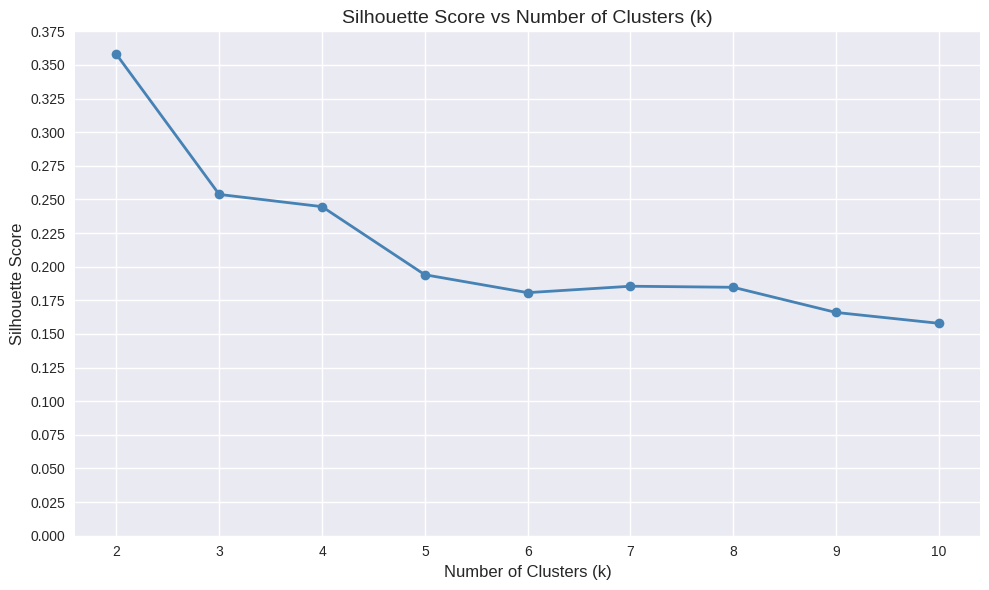

In [47]:


# Data
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_scores = [0.3578954705773014, 0.2537535324824415, 0.24465208840945074, 0.19403929812737172,
                     0.18071600248768466, 0.18548997674683326, 0.18470850763658486,
                     0.16599651083927566, 0.15791932196053513]

# Plotting
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', color='steelblue', linewidth=2)
plt.title('Silhouette Score vs Number of Clusters (k)', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.xticks(k_values)
plt.yticks(np.arange(0,.4, .025))
plt.grid(True)
plt.tight_layout()

# Save plot
output_path = "visuals/silhouette_vs_k.png"
plt.savefig(output_path)

##  Centroid Analysis and PCA Projection

I wanted to look a little deeper into the clusters that were formed and understand how tactics were represented and expresssed using KMeans Clustering. First, I started by finding the centroid, or the average profile of team found within a given cluster. For example, what standardized metrics trend positively for Cluster 0? Finding the answer to this question helps better define the overall tactic trends of that given cluster.

In [19]:
centroids = pipeline["kmeans"].cluster_centers_

In [20]:
centroids

array([[ 0.24812006,  1.77151411, -0.46563218,  0.12642018, -0.12029593],
       [ 7.66318299,  0.15421677,  0.86758231,  0.20379455,  0.09715306],
       [ 2.11981547, -1.71347128, -0.48031386, -0.14402219,  0.13827285],
       [-3.09670006, -0.32893224, -0.10259484, -0.85195811, -0.33826189],
       [-4.66708174, -0.75565491,  1.16784972,  1.16011887,  0.51477665]])

These centroids calculated refer to our clusters post-PCA, which is not necessarily helpful for interpretation to our original dataset. However, we can scale our engineered and selected features, and find the mean value for each metric, aggregated by cluster. Below is a visualization of the average score for each metric per cluster.


In [49]:
# Get cluster labels
labels = pipeline["kmeans"].labels_

# Get engineered + scaled features (before PCA)
pl_engineered = pipeline["scaler"].transform(pipeline["feature_engineering"].transform(pl)
)

# Convert to DataFrame for readability
X_df = pd.DataFrame(pl_engineered, columns=pipeline["feature_engineering"].feature_names)

# Add cluster labels
X_df["kmeans"] = labels

# Compute centroids in original feature space
centroids_original = X_df.groupby("kmeans").mean()
centroids_original

centroids_original.to_csv('data/centroids.csv')

Index(['xG', 'MP', 'GF', 'GA', 'GD', 'Poss', 'CS', 'CS%', 'G-PK', 'PK',
       'PKatt', 'PKm', 'npxG', 'xGD', 'npxGD', 'xAG', 'xA', 'G-xG', 'np:G-xG',
       'A-xAG', 'npxG/Sh', 'Sh', 'G/Sh', 'G/SoT', 'SoT', 'SoT%', 'Dist', 'FK'],
      dtype='object')


In [22]:
centroids_original

,xG,npxG,Poss,Sh,SoT,G/Sh,G/SoT,npxG/Sh,CS%,Dist,...,xGA,xG_xGA_ratio,GF_GA_ratio,finishing_efficiency,assist_efficiency,pressing_intensity,directness,verticality,shot_quality,defensive_efficiency
kmeans,,,,,,,,,,,,,,,,,,,,,
0,-0.127351,-0.138453,-0.134168,-0.355423,-0.109099,0.678282,0.598543,0.347157,-0.159128,-0.236530,...,0.153037,-0.267103,-0.129743,0.673941,0.699807,0.403259,-0.415808,0.170332,0.381115,-0.113710
1,1.677233,1.697868,1.653815,1.645786,1.595245,1.305077,1.328171,0.890685,1.719255,-0.510634,...,-1.701931,2.164703,2.285638,1.068804,0.988829,-0.491169,0.505610,-1.418497,0.928174,-0.502312
2,0.796915,0.811822,0.529286,0.837977,0.791626,0.012359,-0.080165,0.535896,0.392947,-0.279467,...,-0.384101,0.434883,0.236626,-0.246563,-0.341342,-0.704624,0.742932,-0.872701,0.485416,-0.080439
3,-0.721328,-0.731009,-0.908360,-0.576334,-0.710264,-0.646182,-0.514116,-0.686353,-0.673932,0.351050,...,0.655409,-0.654911,-0.667199,-0.386298,-0.467619,-0.367676,0.294004,0.580435,-0.702697,0.365179
4,-1.064492,-1.063936,-0.335436,-0.857855,-1.048399,-1.415670,-1.343011,-1.109621,-0.510136,0.741648,...,0.526013,-0.726000,-0.794467,-1.257021,-0.977483,1.175907,-1.099132,1.110990,-1.108911,0.161871


We can then plot these centroids across each cluster to gain a holistic view of how each cluster may be interpreted and represented as tactical profiles.

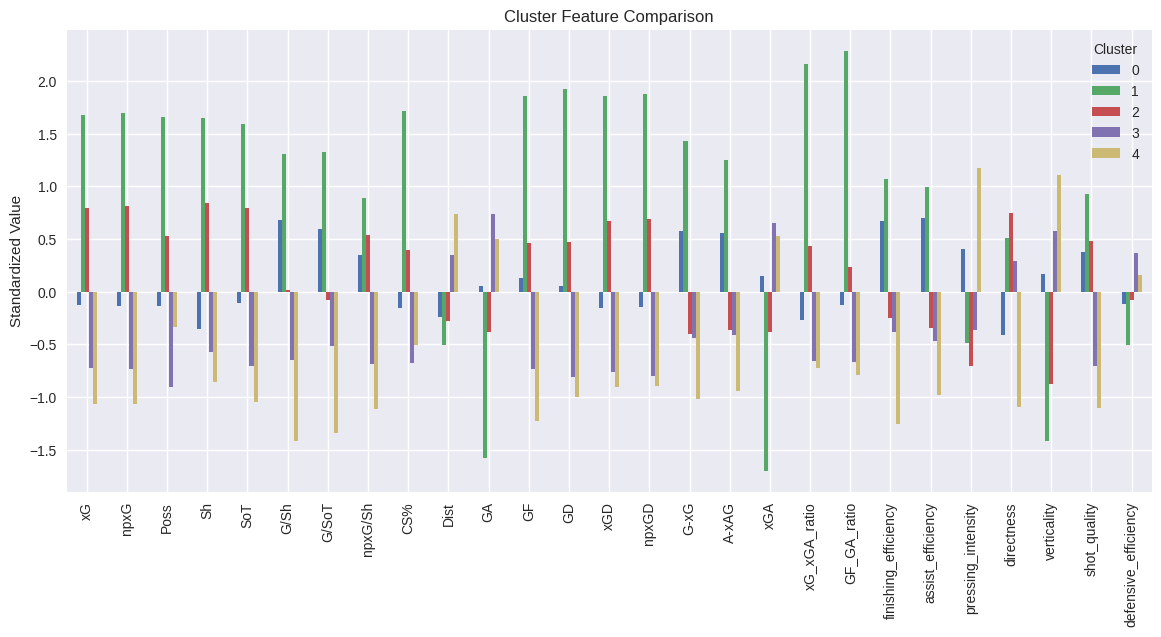

In [23]:
centroids_original.T.plot(kind="bar", figsize=(14,6))
plt.title("Cluster Feature Comparison")
plt.ylabel("Standardized Value")
plt.legend(title="Cluster")
plt.show()

**Cluster 1: League Leaders/Front Runners**

Elite Teams that overwhelmingly excel in every metric. Both the *Expected Goals to Expected Goals Against* ratio and *Goals Scored to Goals Conceded* ratios tend incredibly positive. Given how we chose to engineer our *verticality* feature, it is also not a surprise these teams tend to focus on controlling possession, short and lateral pass, and build slowly. A negative *pressing_intensity* score denotes less time spent pressing, given that these teams would have the ball for more of the game. The Front Runners are defensively sound, with high *Clean Sheet %* and massively negative *GA*. Within this specific period of the Premier League, Man City, Liverpool and, much more recently, my Gunners fall into this category. The Beautiful Game, packed into recognizable systems and entertaining interplay.

**Cluster 4: Relegation Shamblers**

Where do we start? Positive scores in the metrics you don't want to be positive. We're talking *Dist*, *GA*, and *xGA*.The *Dist* stat, for instance, being high denotes a tendency to shoot from longer distances and longer passes. These teams also trend negatively in most phases of play. Shots on goal, goals scored, goal difference, possession, etc. However, what is interesting is that these teams tend to have a very low average *directness* while they have very high *verticality*. In contrast, the Front Runners tend to play way less vertically but progress the ball towards goal at a positive rate. Both metrics are meant to correlate, yet both clusters differ drastically in the range of scores.  Shamblers are not progressing the ball and when they do, they are just clearing the ball and hoping for the best. Rarely creating chance but not defending well either. No cohesion, just chaos. Southampton 2024-2025, I am looking at you.

**Cluster 2: Neutrals' Favorite**

Otherwise known, in some cases, as the "The Best of the Rest", these teams favor high-tempo and exciting football. Similar to our Front Runners, they score often and like to keep possesion, trending positively in *xG*, *Shots*, *SoT*, and keeping a positive *Clean Sheet %* average and a decent average *GA*. But what keeps the Best of the Rest out of the title race tends to be their offensive efficiency. These teams tend to have negative *Goals - Expected Goals* and *Assists - Expected Assist*, showing an underperformance in their offensive potential. Funnily enough, during the 2024-2025 season, Man City fell into this category. You may recall their mid season stumble, where they lost games to team they should have put away and were not scoring like normal. I think of Newcastle of the last few years or a mid 2010s Everton with Lukaku up front. Last year's Crystal Palace team fell within this cluster as well.

**Cluster 0: Direct with Purpose**

Teams that tend to focus on playing on the transistion, playing on the counter and pressing intensely. They are focused more on *verticality* and *directness*, rather than keeping possession and intricate positional play. While the standardized score is negative, that does not mean they do not play direct. They don't turn on the counter immeadiately but pick their moments, which is supported by their verticality in addition to thier assist and finishing efficiency. They get forward, shoot accurately and score when it counts. Managers like Sean Dyche favor these old school tactics, as it has been proven to get teams to safety and keep them there. Hoof it up to the big man up top and go from there. Get crosses in from the wing. Route One Footy.

**Cluster 3: Stalwarts**

Survivalists at their core, these teams want to absorb pressure and sit back in a low block. They tend to react, rather impose their will on the opposition. High *directness* and High *verticality* with very low possession. They won't even press very intensely, forcing the opposition to try and break down their compact struture. With all that focus on defending, these teams are always flirting with the relegation, as they are still conceding way more than their competition. That being said, they have a relatively positive defensive efficiency, meaning they are not conceding as many goals as expected. Sam Allardyce and Tony Pulis come to mind, personally when i think of these teams.


In [36]:
def remap(df):
  if df['cluster'] == 0:
    return "Direct with Purpose"
  elif df['cluster'] == 1:
    return "League Leaders/Front Runners"
  elif df['cluster'] == 2:
    return "Neutrals' Favorite"
  elif df['cluster'] == 3:
    return "Stalwarts"
  else:
    return "Relegation Shamblers"

In [37]:
df_clusters['cluster_name'] = df_clusters.apply(remap, axis=1)

I wanted to see how we could

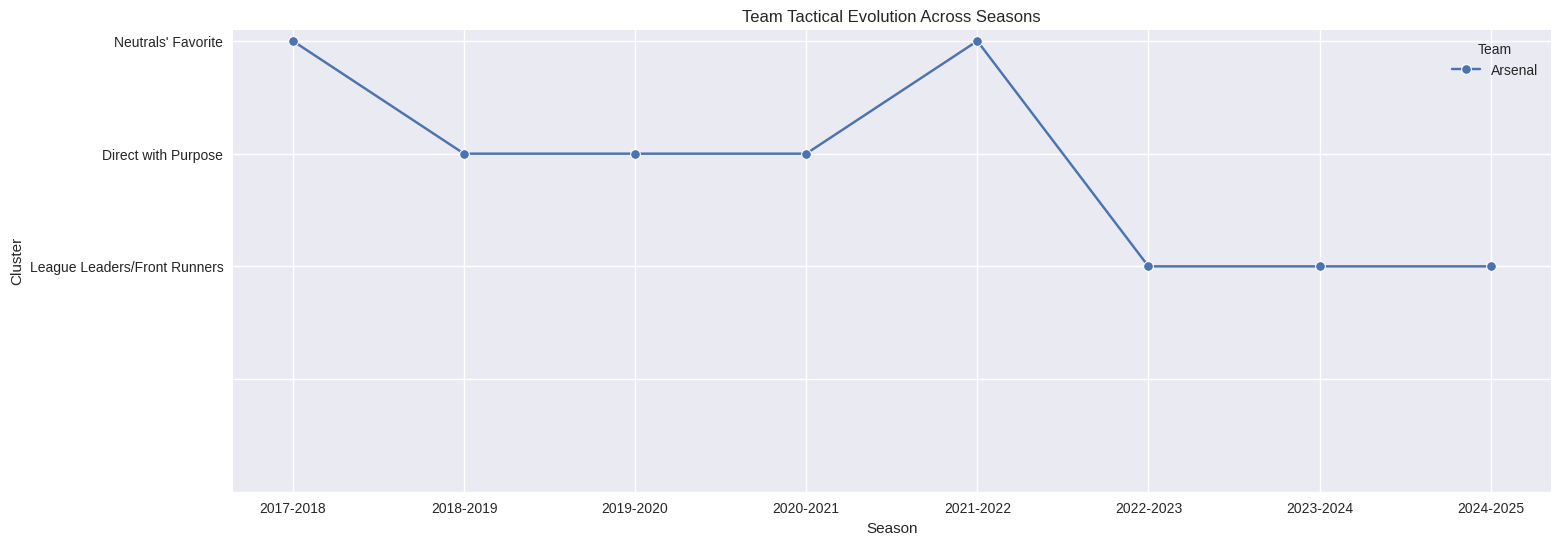

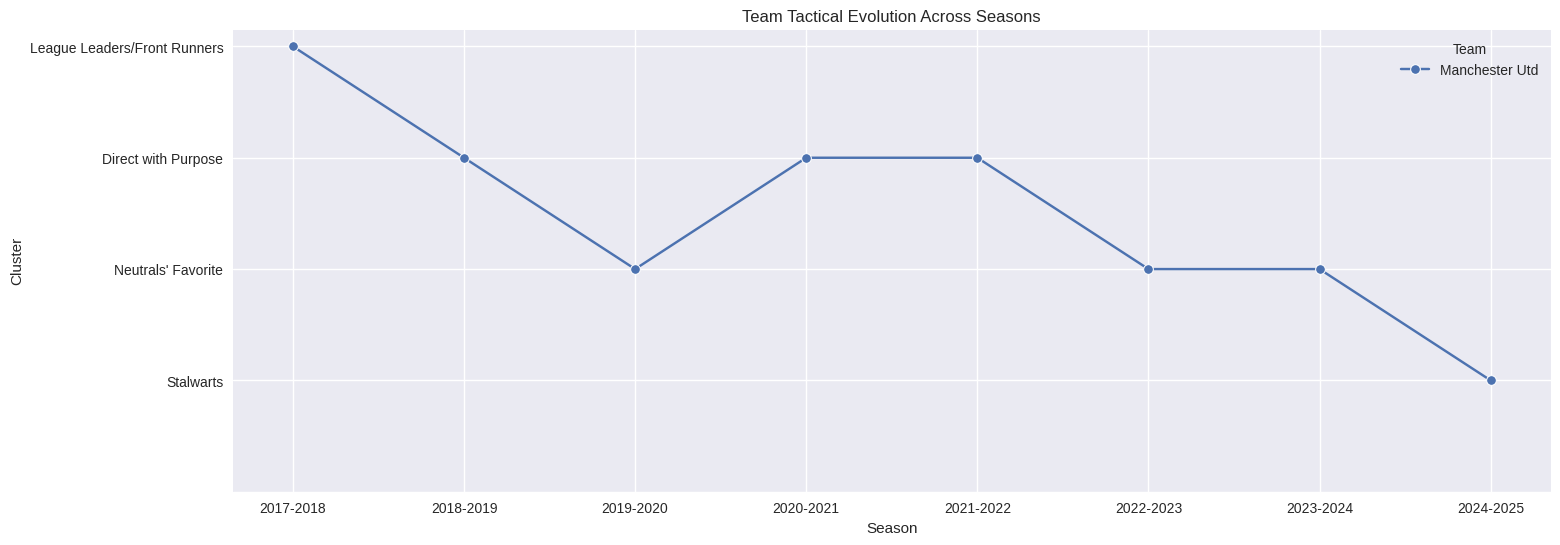

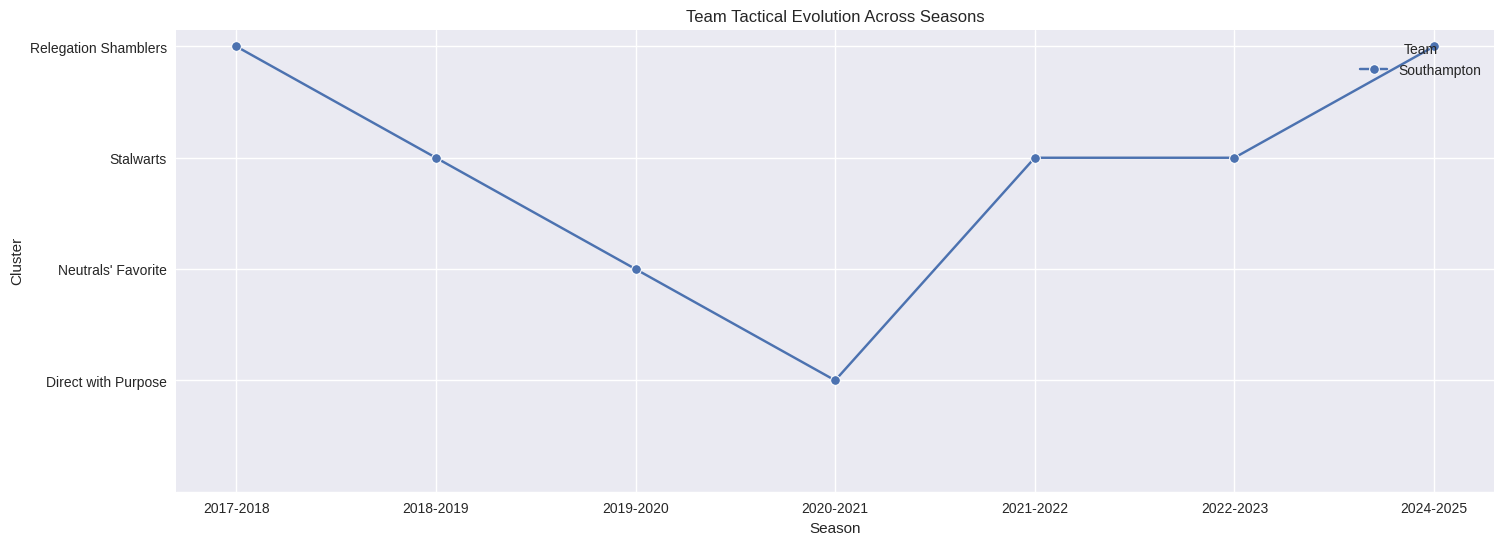

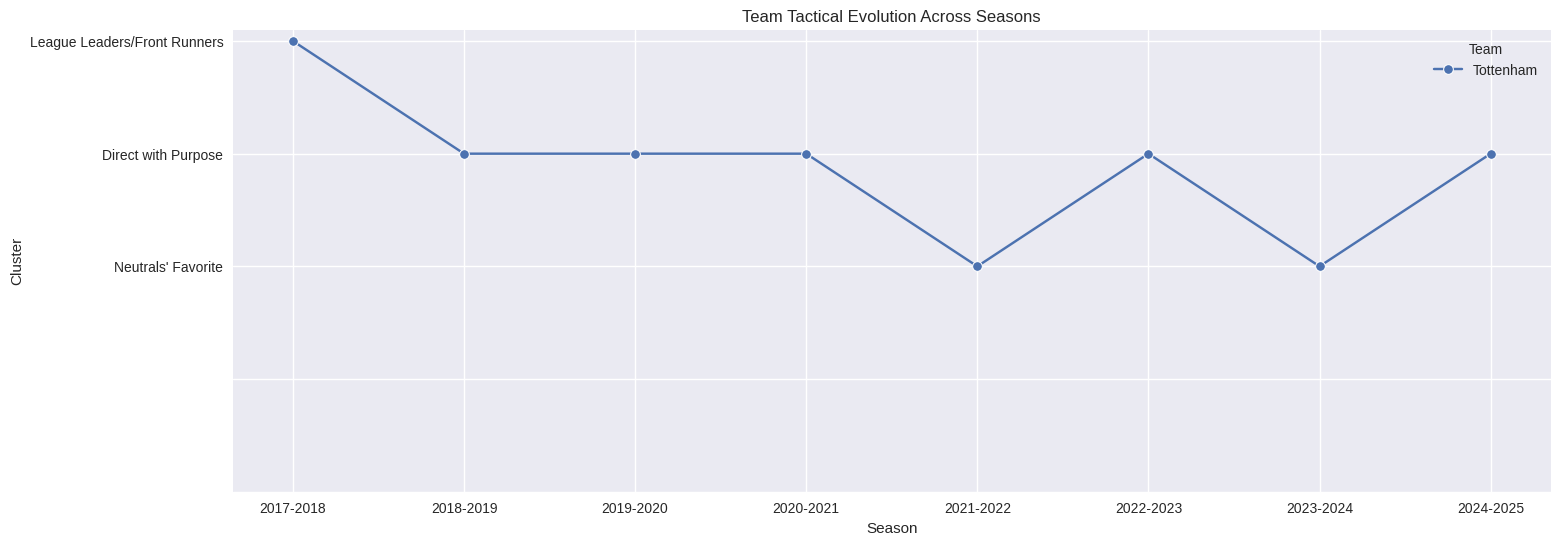

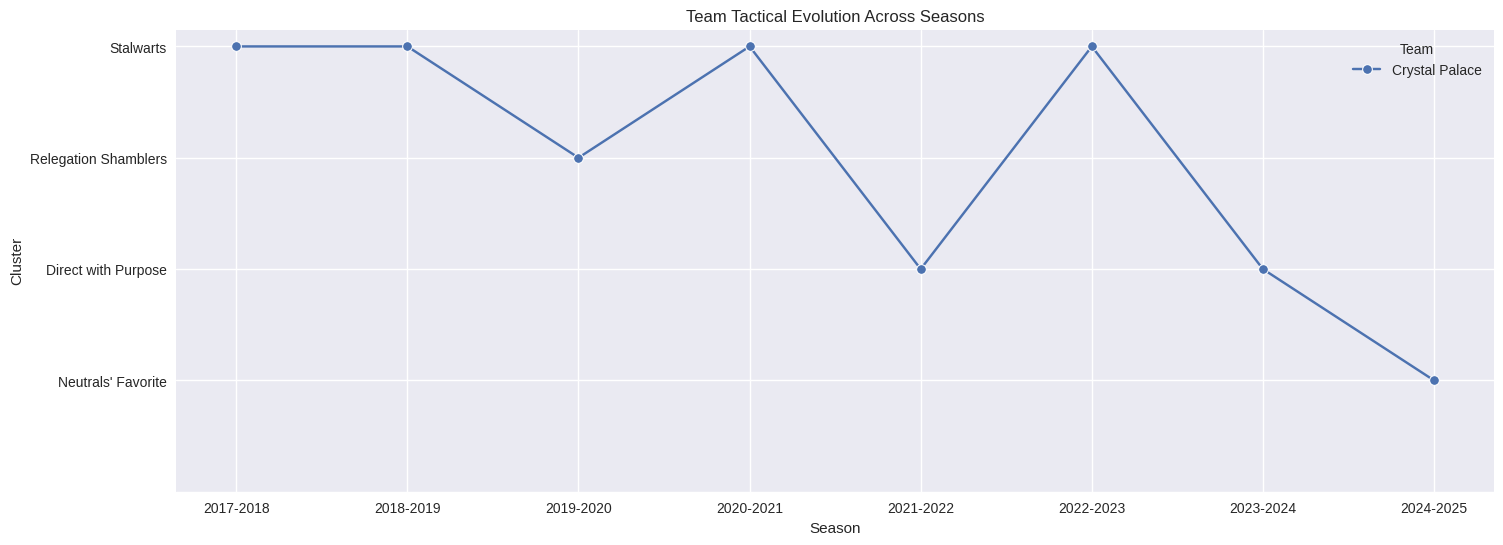

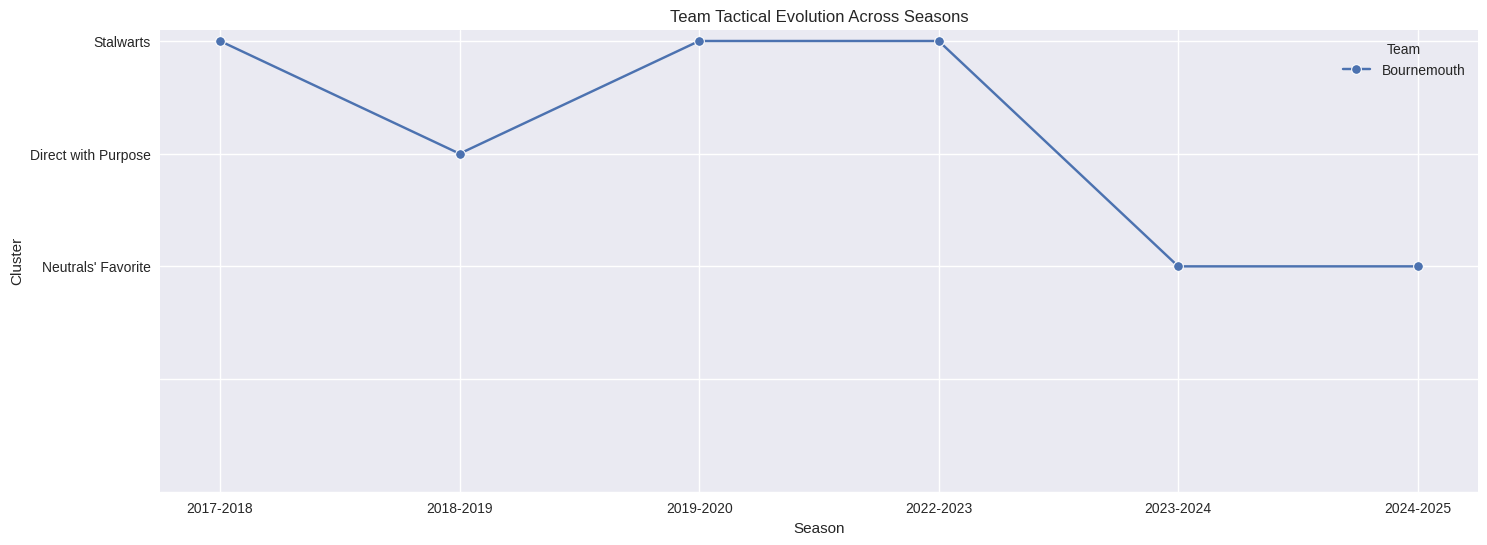

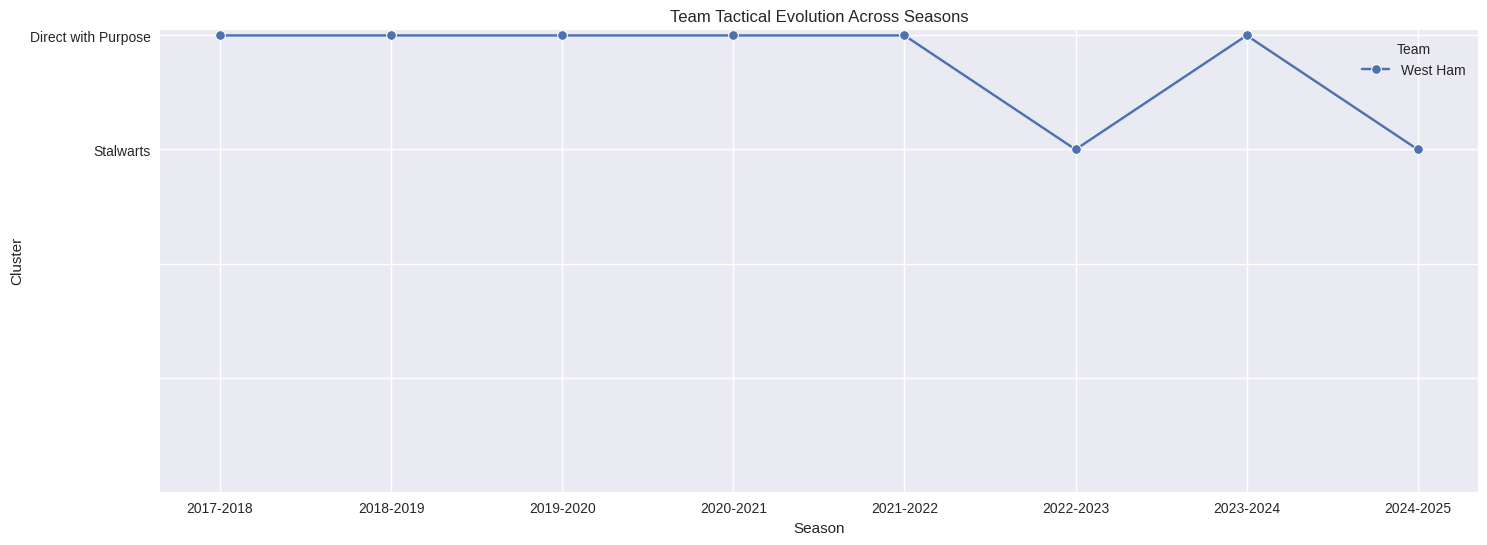

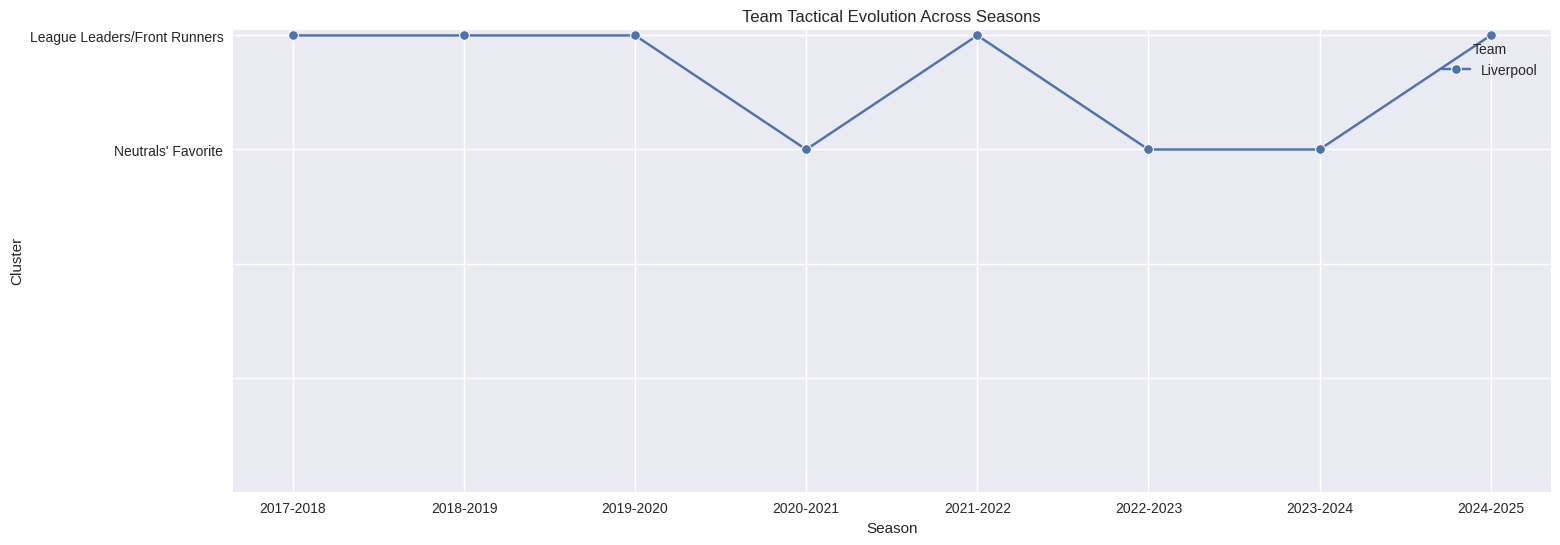

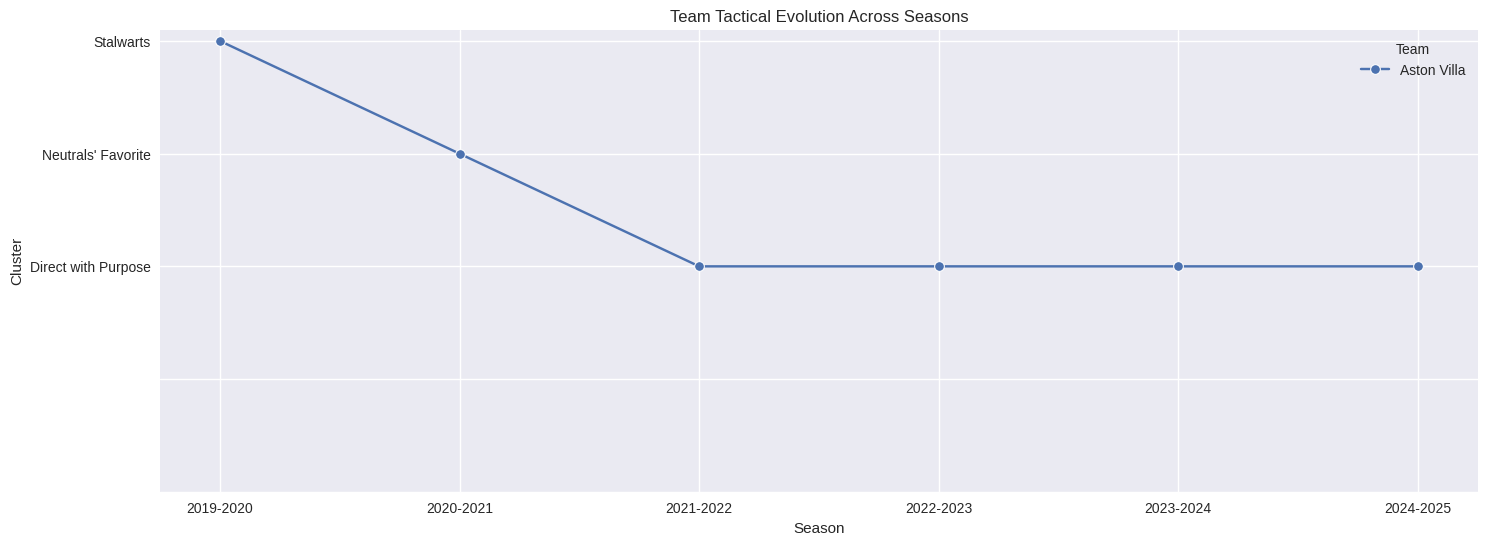

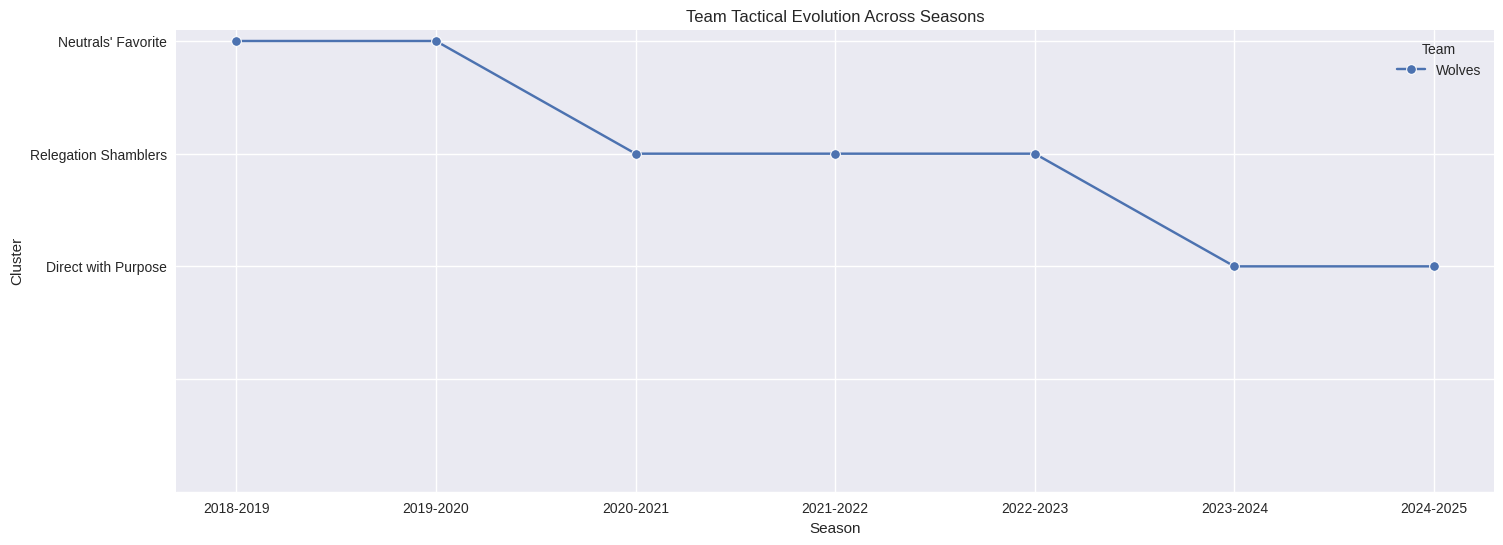

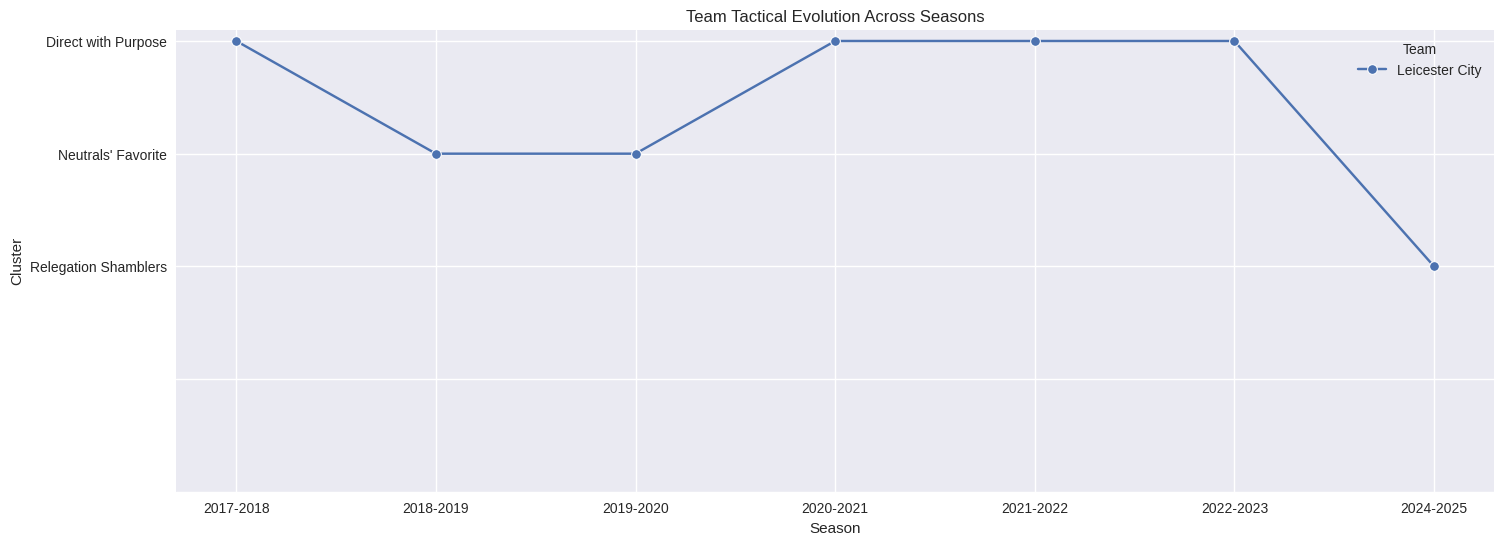

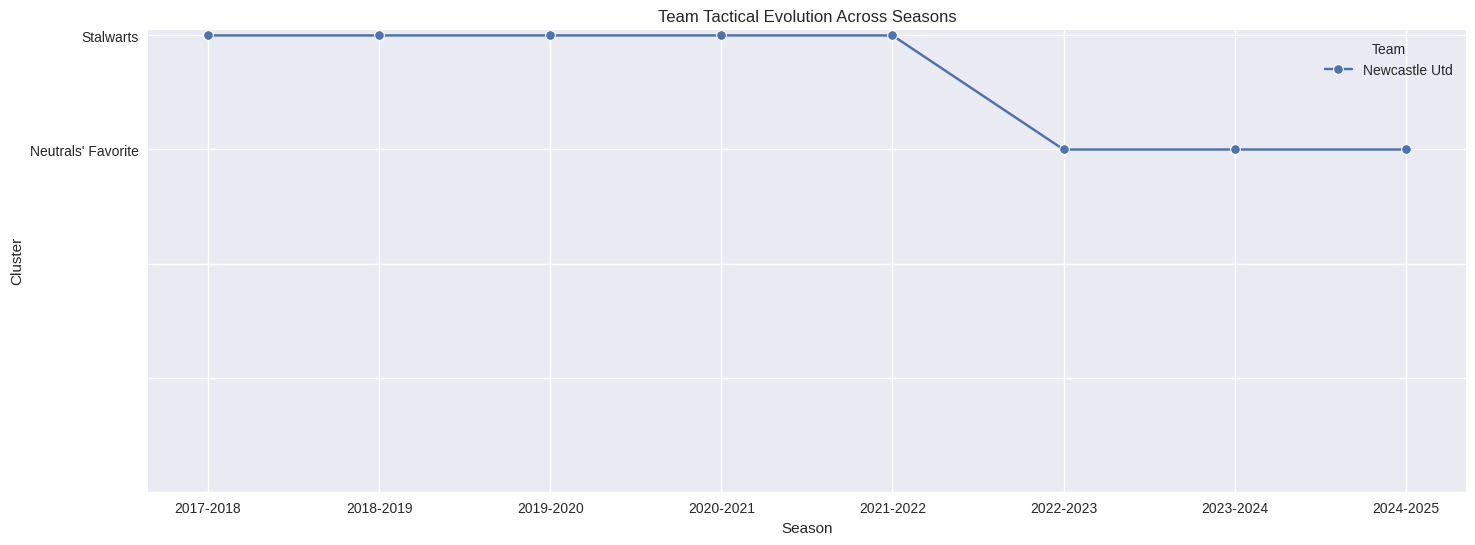

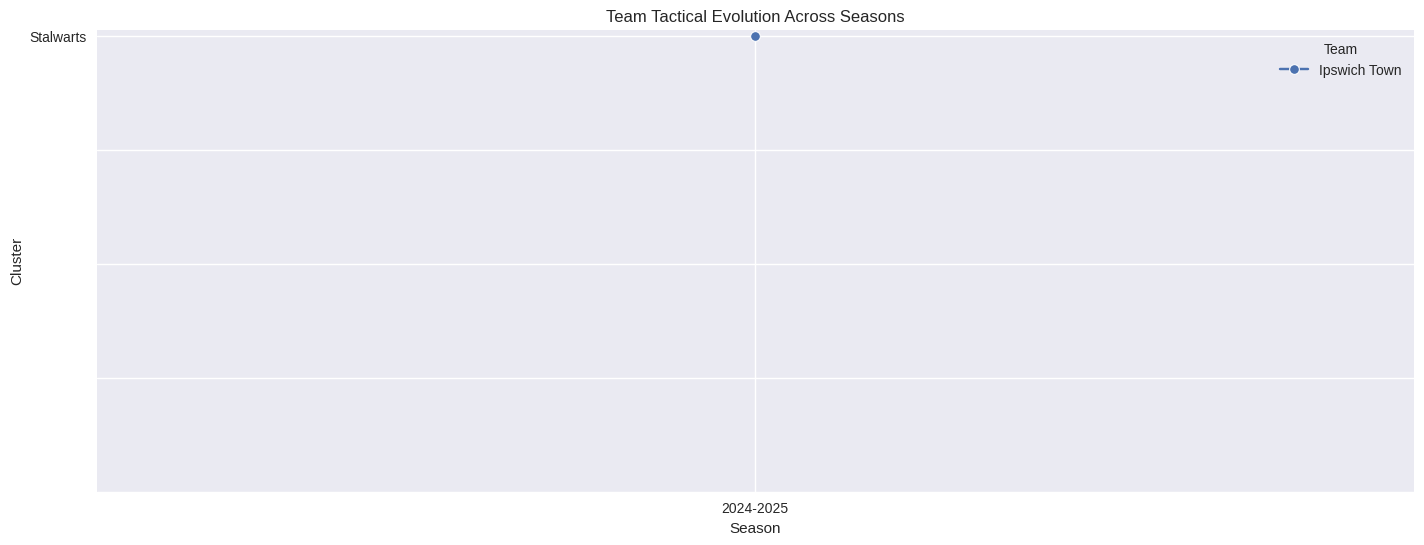

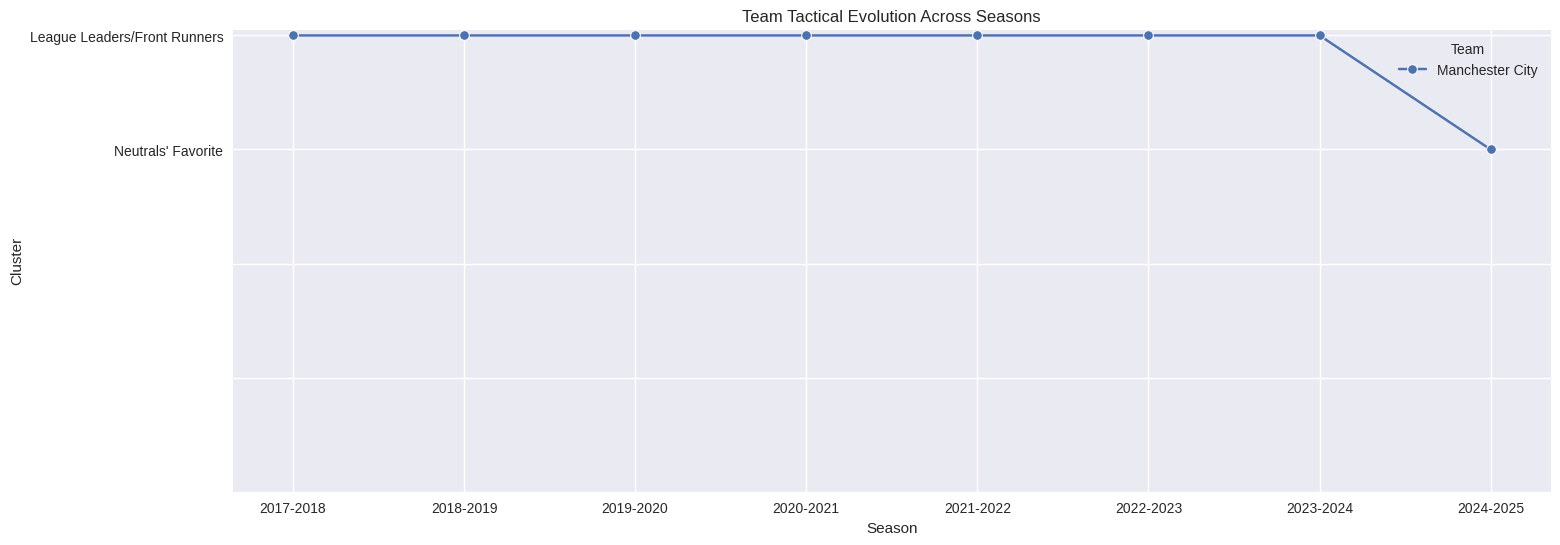

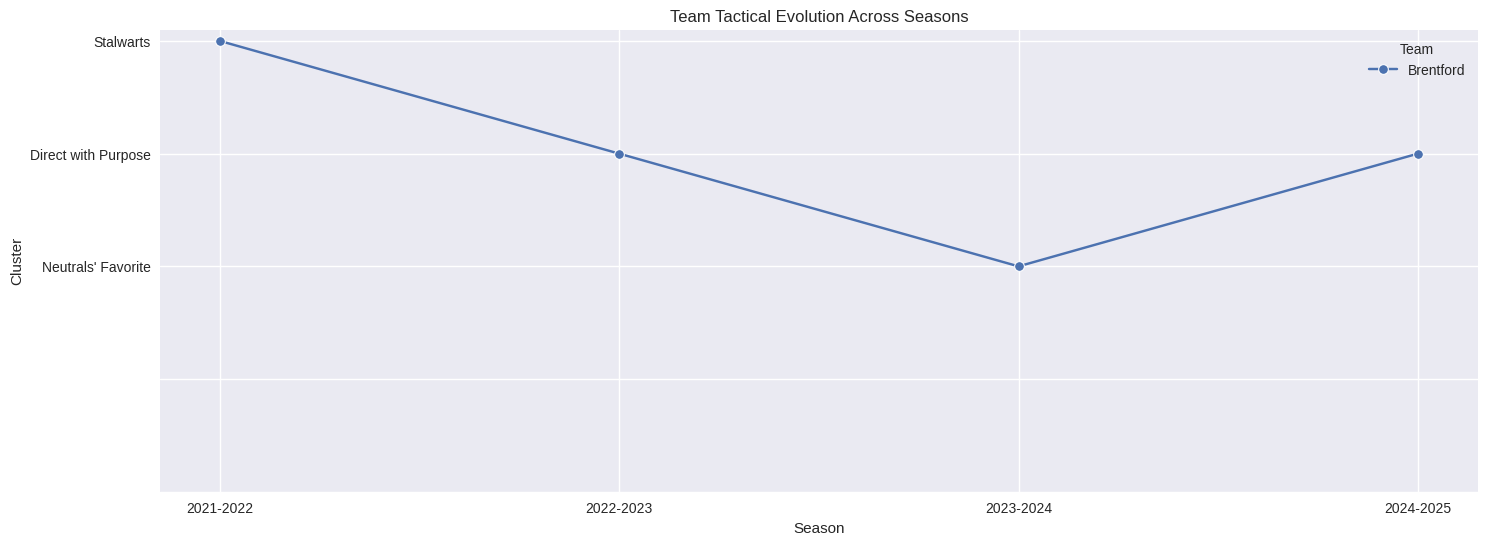

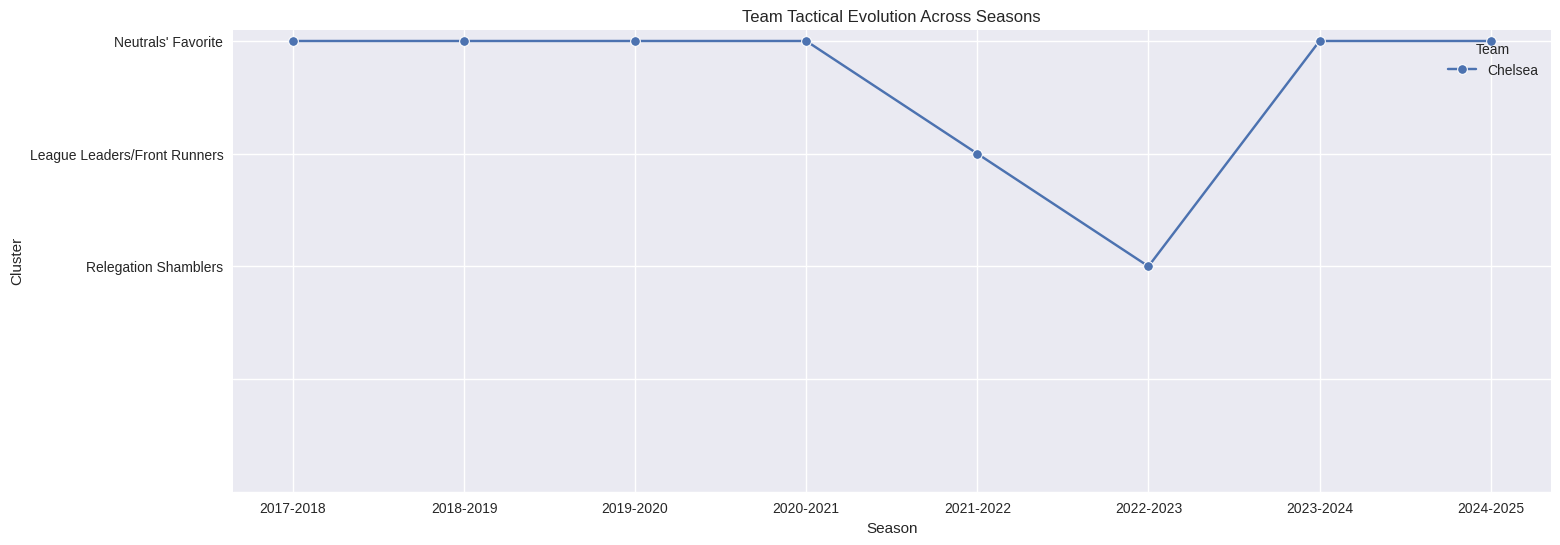

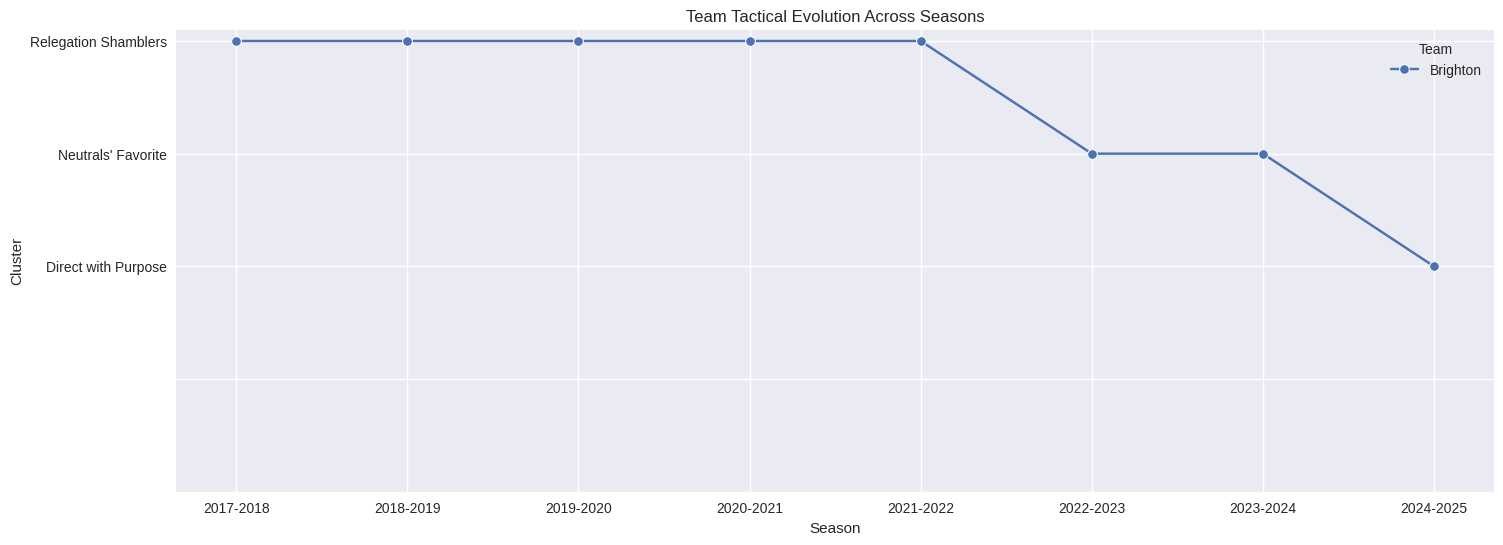

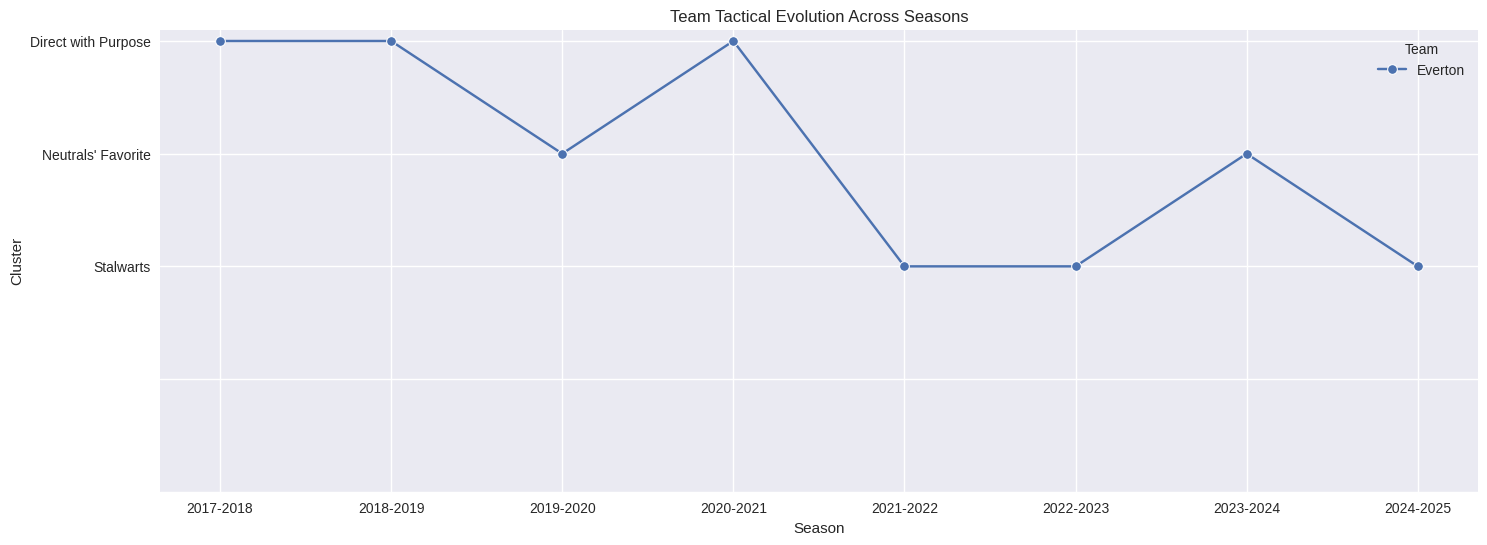

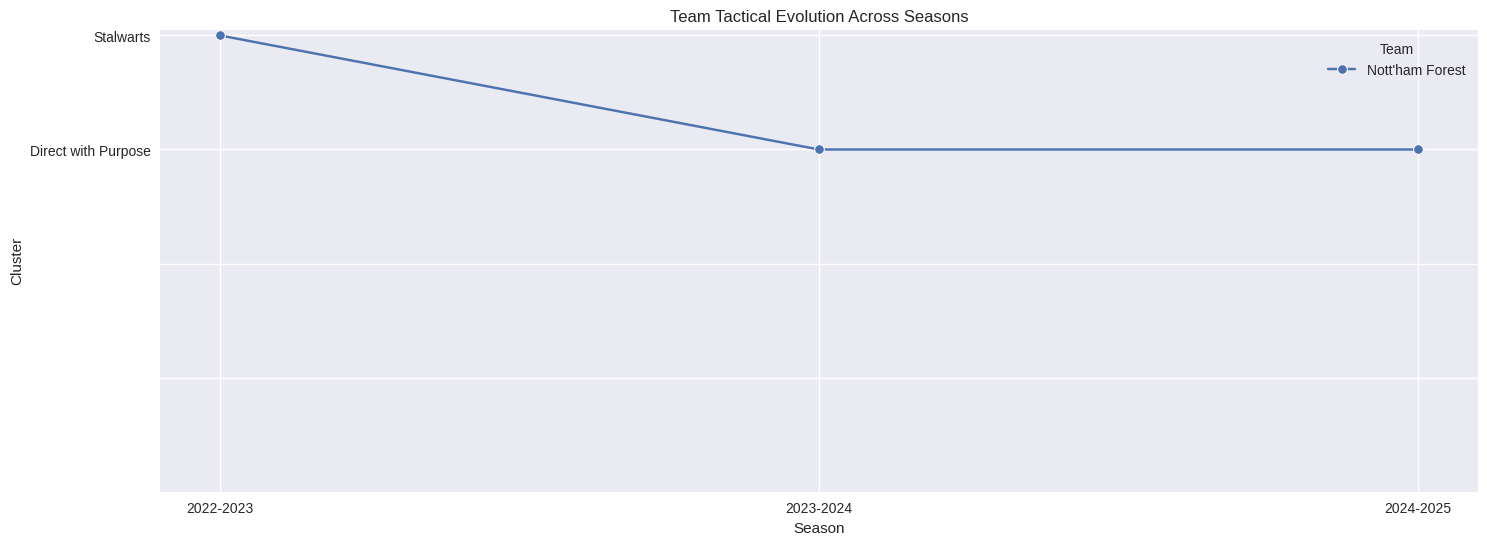

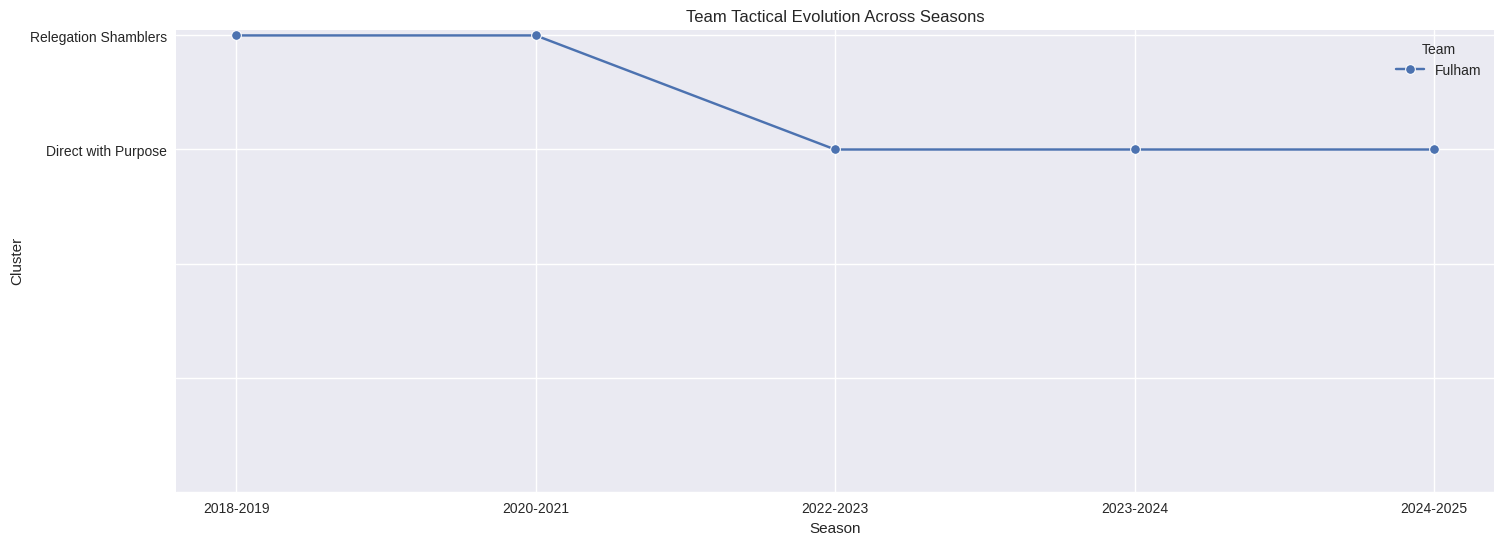

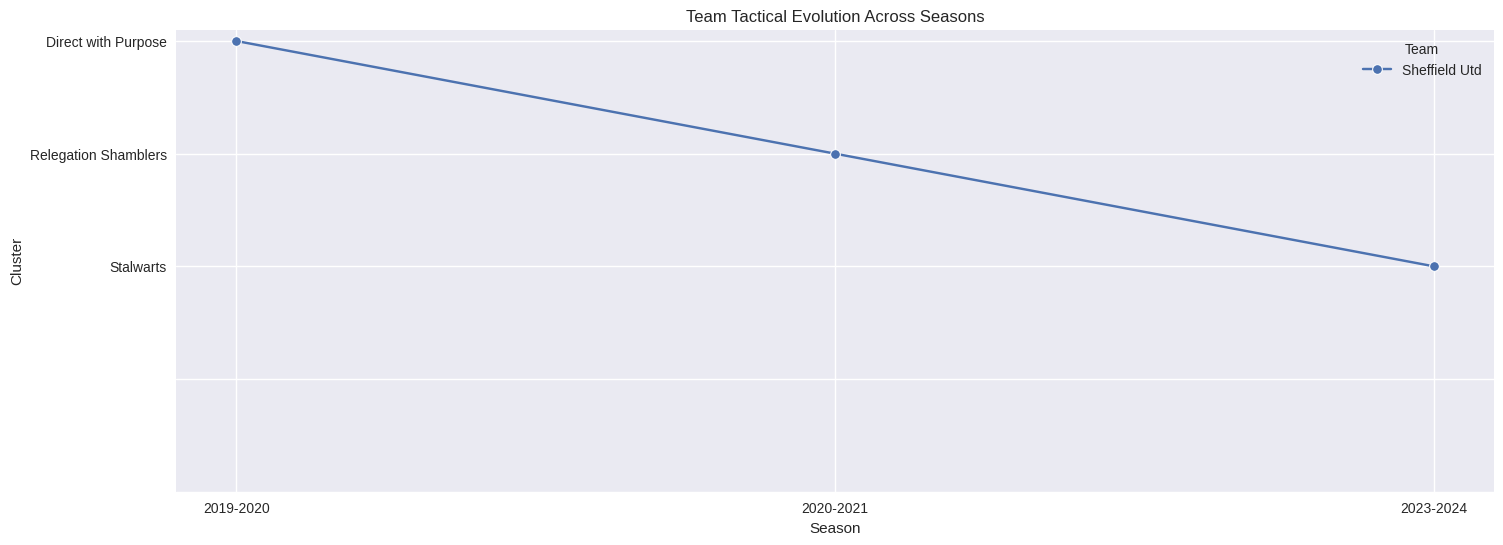

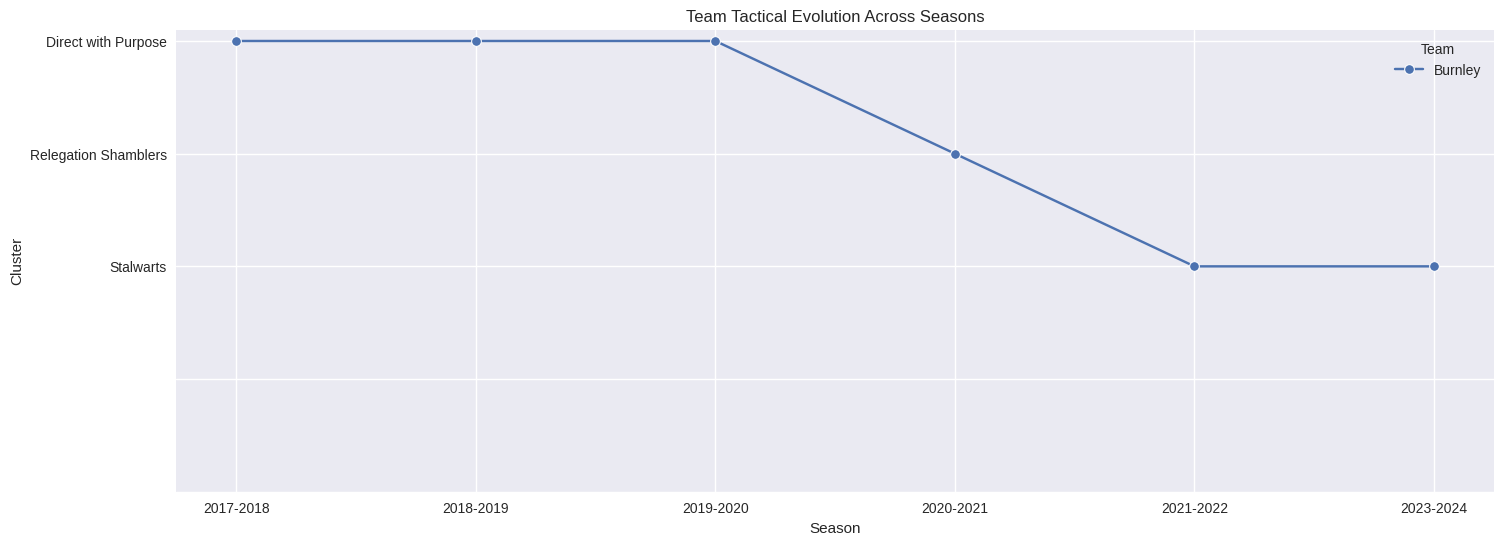

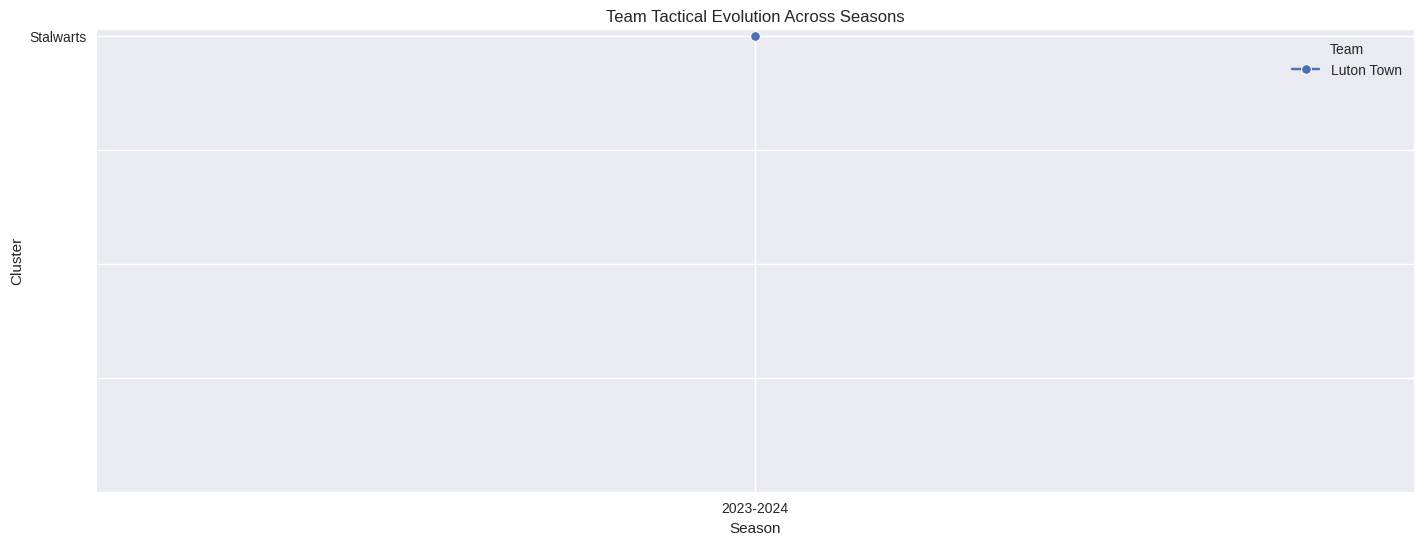

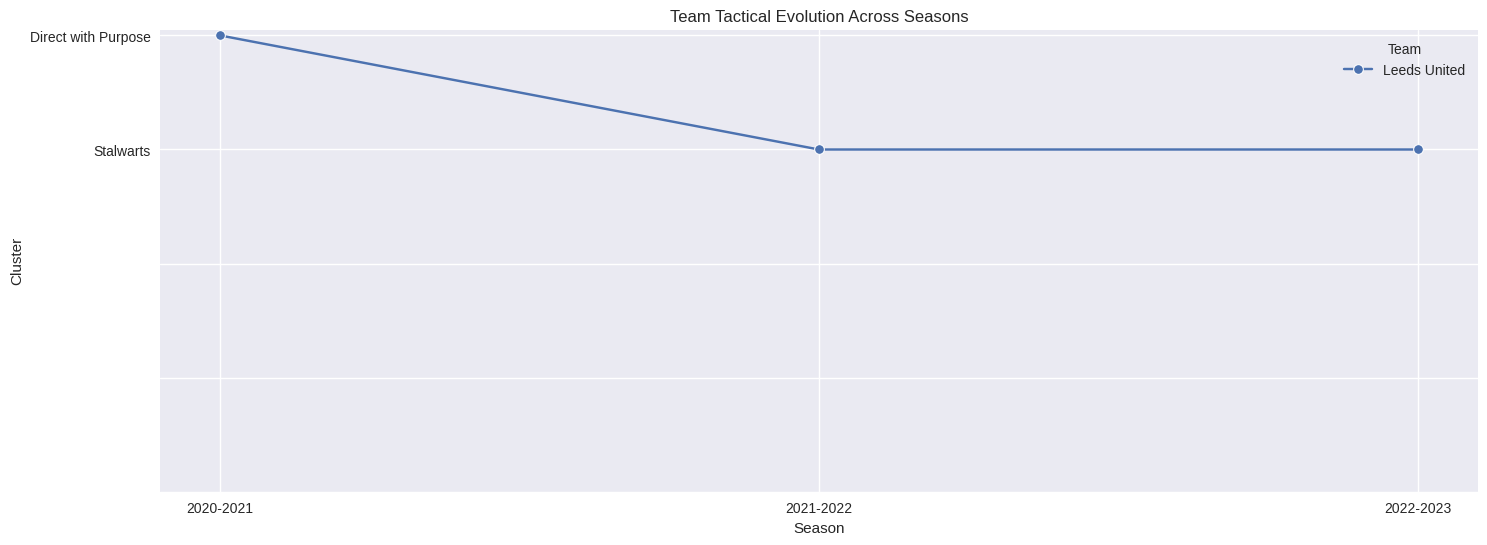

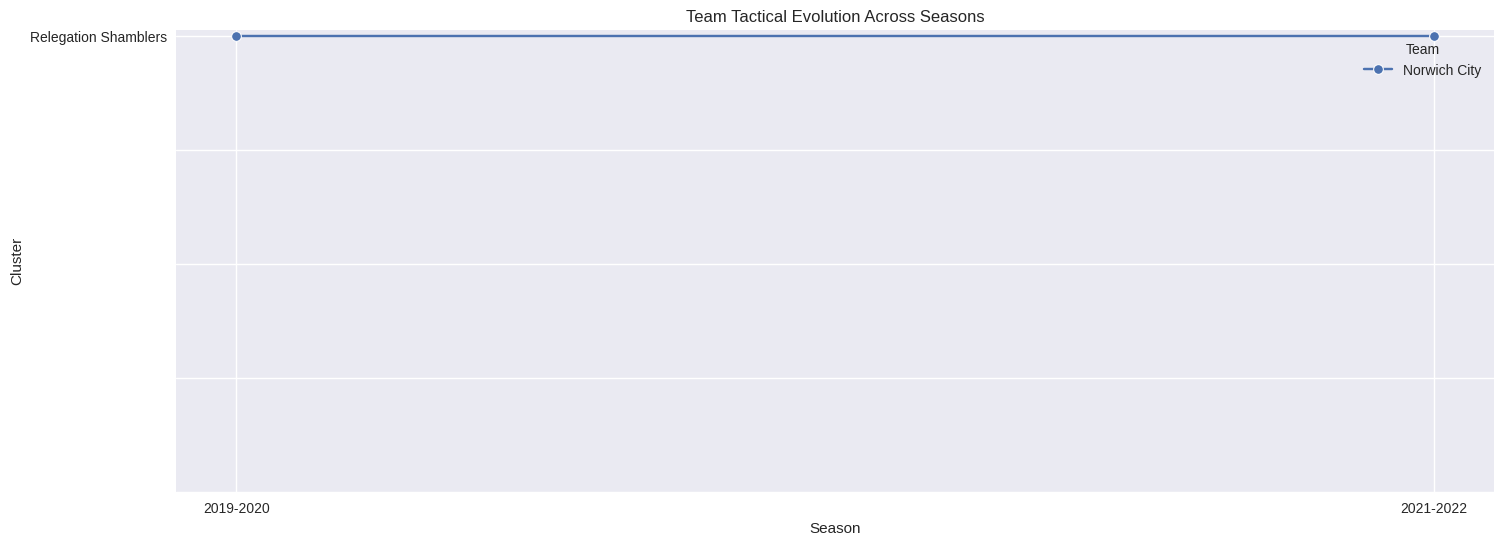

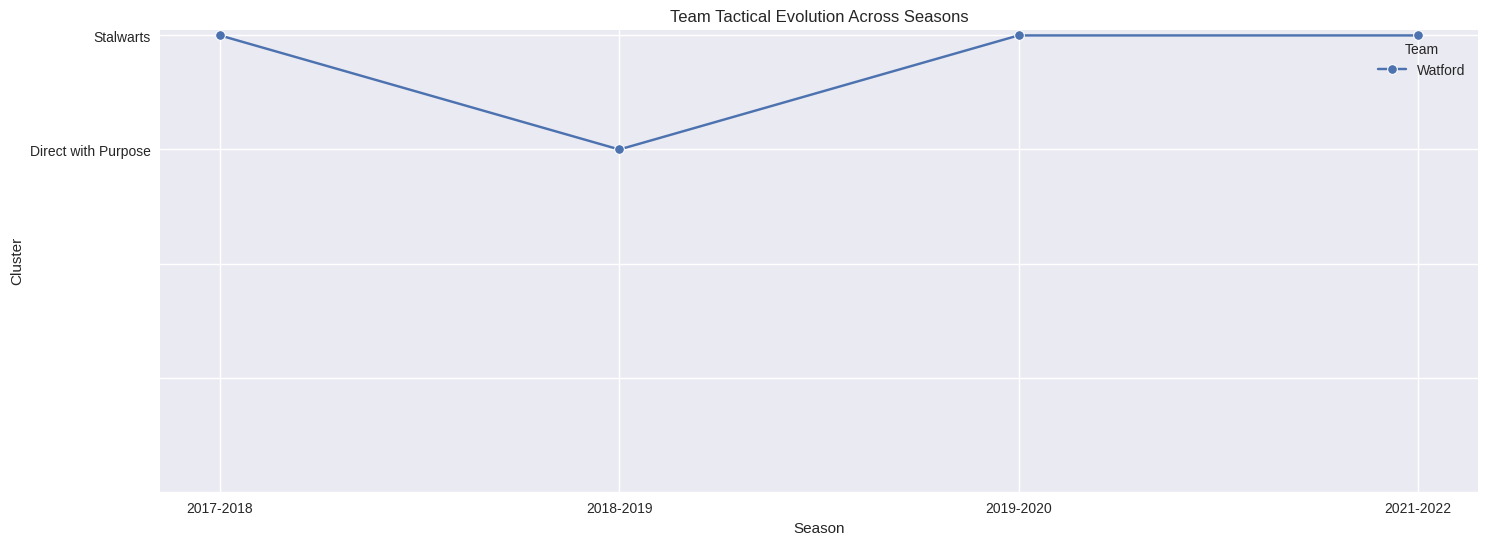

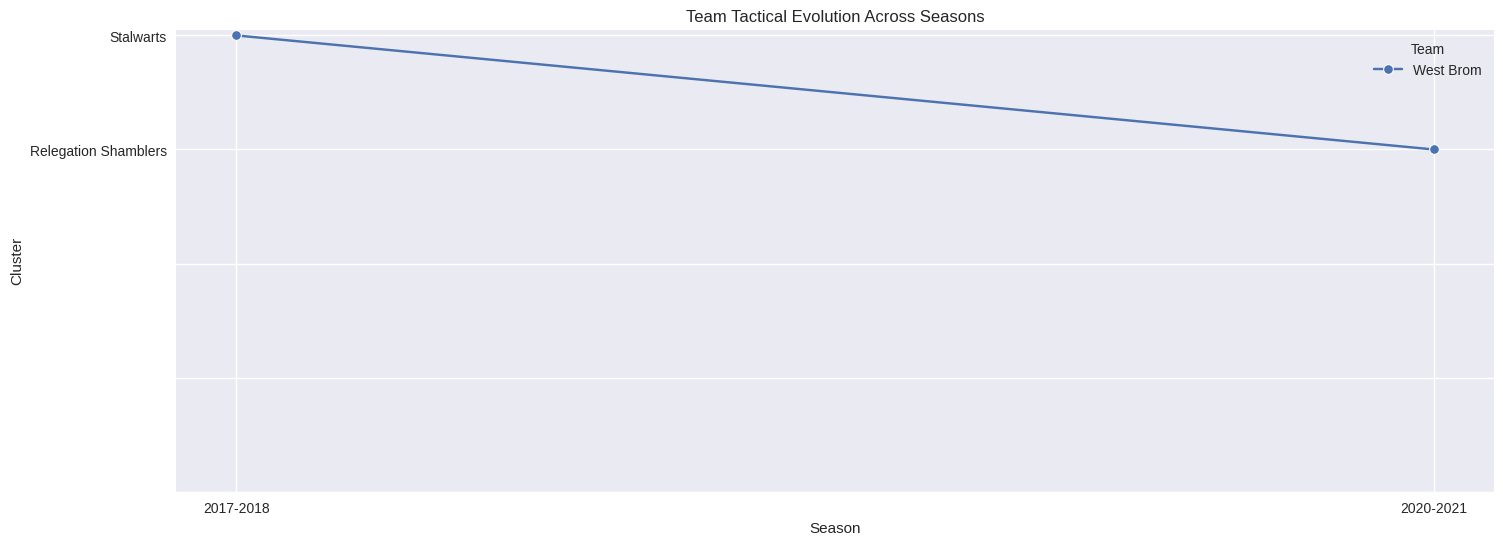

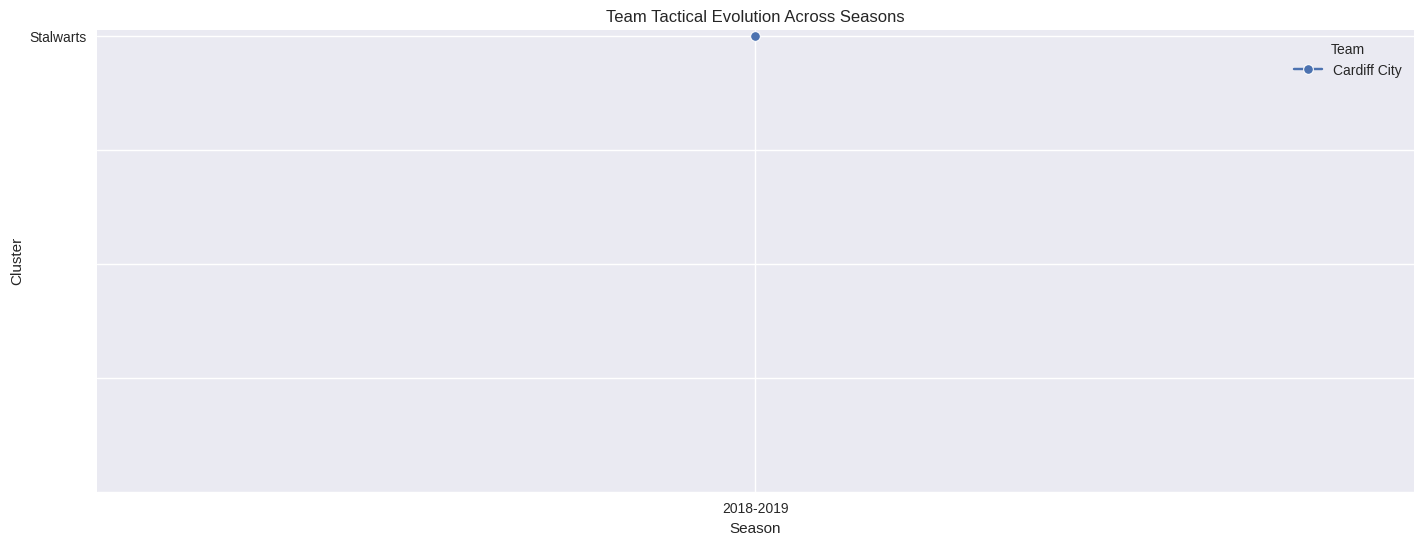

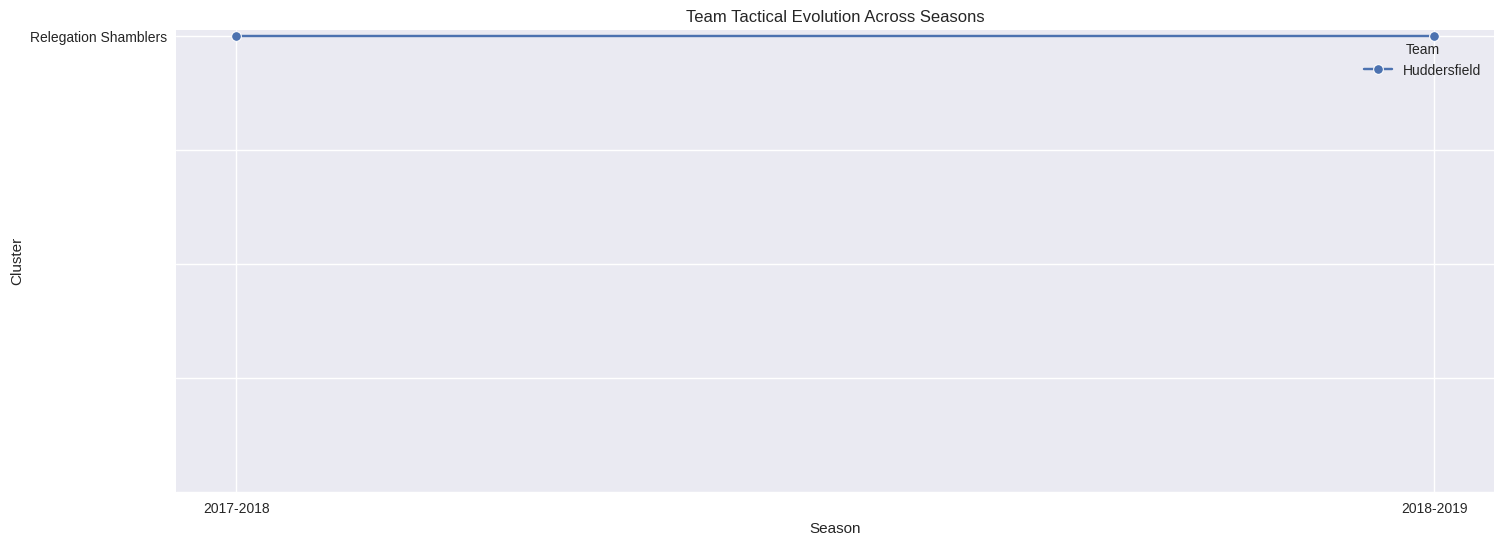

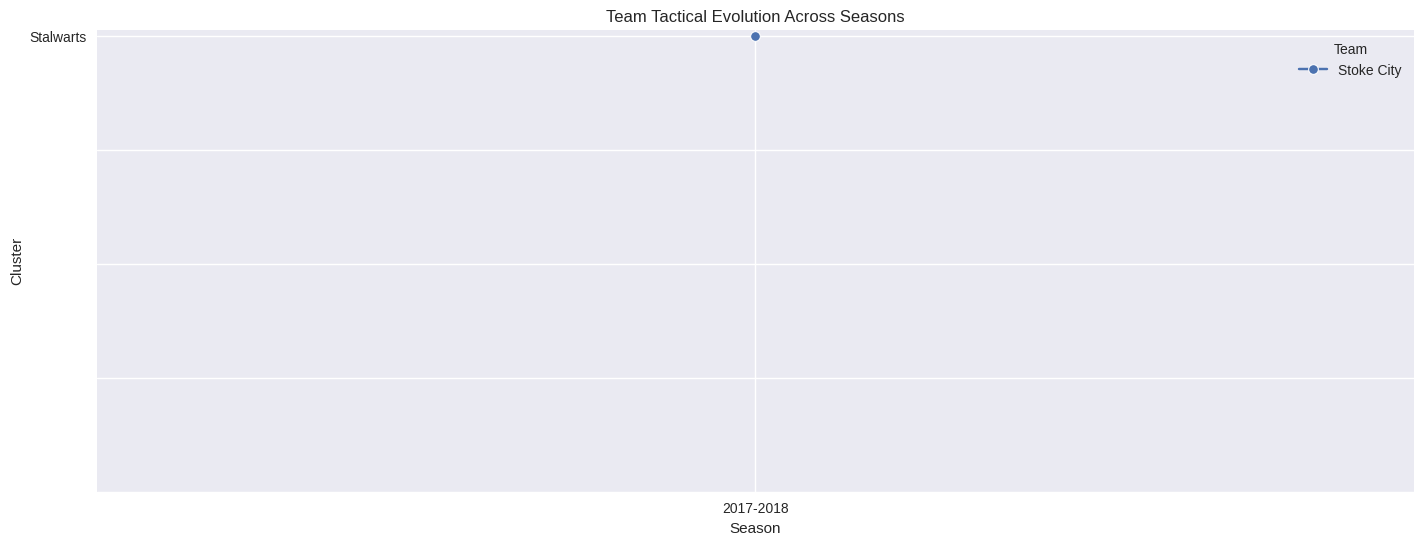

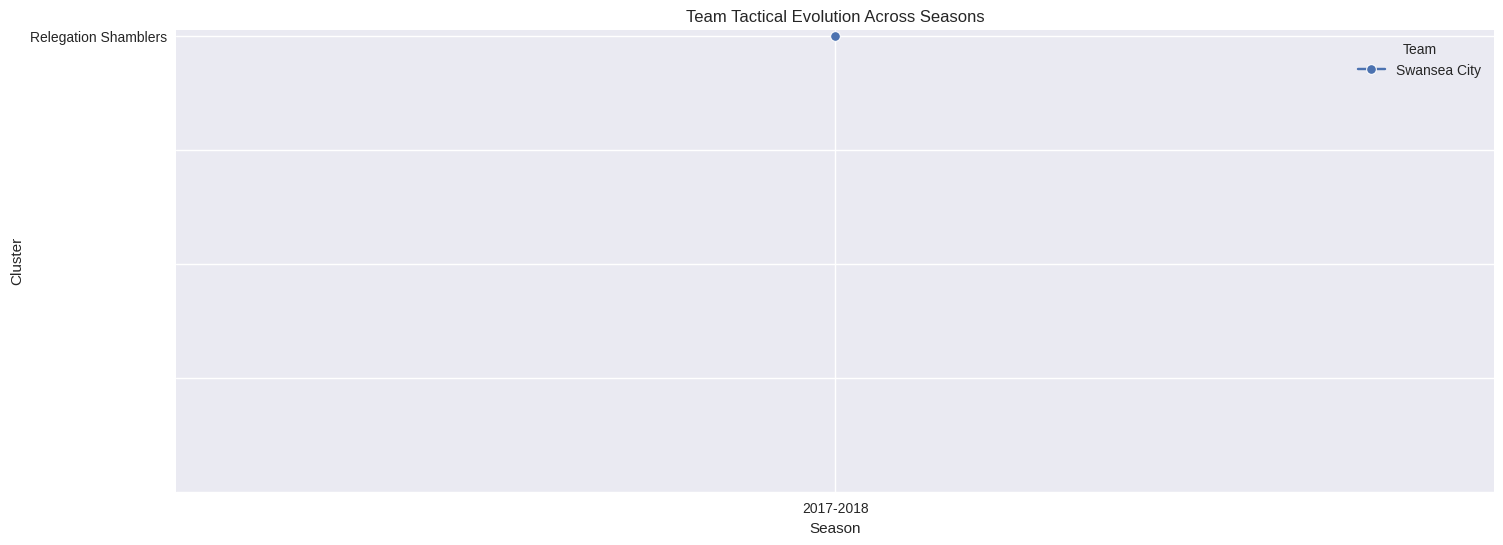

In [50]:
for t in df_clusters['Team'].unique():
    plt.figure(figsize=(17,6))
    team = df_clusters[df_clusters['Team'] == t].sort_values(by='Season', ascending=True)
    charts= sns.lineplot(
        data=team,
        x="Season",
        y="cluster_name",
        hue="Team",
        marker="o"
    )
    sns.move_legend(charts, "upper right")
    plt.title("Team Tactical Evolution Across Seasons")
    plt.ylabel("Cluster")
    plt.yticks(np.arange(0, 5, 1))
    plt.savefig('Team Tactical Evolution Across Seasons_'+t+'.png')
    plt.show()

In [43]:
df_clusters[df_clusters['Team'] == "Everton"][df_clusters['Season'] == '2023-2024'].T

/tmp/ipython-input-2434591623.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clusters[df_clusters['Team'] == "Everton"][df_clusters['Season'] == '2023-2024'].T


,36
Rk,37
Season,2023-2024
Team,Everton
Comp,eng Premier League
xG,54.0
MP,38
W,13
D,9
L,16
Pts,48


In [42]:
df_clusters[df_clusters['Team'] == "Chelsea"][df_clusters['Season'] == '2022-2023'].T

/tmp/ipython-input-2200973725.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clusters[df_clusters['Team'] == "Chelsea"][df_clusters['Season'] == '2022-2023'].T


,55
Rk,56
Season,2022-2023
Team,Chelsea
Comp,eng Premier League
xG,49.5
MP,38
W,11
D,11
L,16
Pts,44


In [44]:
df_clusters[df_clusters['cluster'] == 2]

,Rk,Season,Team,Comp,xG,MP,W,D,L,Pts,...,npxG/Sh,Sh,G/Sh,G/SoT,SoT,SoT%,Dist,FK,cluster,cluster_name
4,5,2024-2025,Crystal Palace,eng Premier League,60.4,38,13,14,11,53,...,0.11,512,0.09,0.26,175,34.2,16.8,19,2,Neutrals' Favorite
5,6,2024-2025,Bournemouth,eng Premier League,64.0,38,15,11,12,56,...,0.10,574,0.09,0.27,192,33.4,16.7,10,2,Neutrals' Favorite
11,12,2024-2025,Newcastle Utd,eng Premier League,63.8,38,20,6,12,66,...,0.12,519,0.12,0.37,163,31.4,15.9,14,2,Neutrals' Favorite
13,14,2024-2025,Manchester City,eng Premier League,68.1,38,21,8,9,71,...,0.11,603,0.11,0.33,208,34.5,16.9,21,2,Neutrals' Favorite
15,16,2024-2025,Chelsea,eng Premier League,67.8,38,20,9,9,69,...,0.11,590,0.10,0.28,203,34.4,16.7,17,2,Neutrals' Favorite
21,22,2023-2024,Manchester Utd,eng Premier League,56.5,38,18,6,14,60,...,0.10,543,0.09,0.28,182,33.5,17.4,15,2,Neutrals' Favorite
23,24,2023-2024,Tottenham,eng Premier League,68.2,38,20,6,12,66,...,0.12,582,0.12,0.32,207,35.6,16.5,11,2,Neutrals' Favorite
25,26,2023-2024,Bournemouth,eng Premier League,55.9,38,13,9,16,48,...,0.10,539,0.09,0.29,175,32.5,16.7,18,2,Neutrals' Favorite
27,28,2023-2024,Liverpool,eng Premier League,87.8,38,24,10,4,82,...,0.11,781,0.09,0.28,263,33.7,17.2,18,2,Neutrals' Favorite
31,32,2023-2024,Newcastle Utd,eng Premier League,76.0,38,18,6,14,60,...,0.13,542,0.14,0.38,196,36.2,15.7,9,2,Neutrals' Favorite


### PCA Mapping

PCA reduces the full feature set into a 2D tactical space that's easier to interpret.
PC1 captures a spectrum from reactive, low-productivity teams (high GA, high xGA, high verticality, low possession) to proactive, high-productivity teams (high xG, shots, GF, GD).
PC2 separates efficient, clinical teams (high finishing efficiency, assist efficiency, G-xG, A-xA) from high-tempo, low-conversion teams (higher directness, lower xG and SoT).
Together, these axes create a tactical map where teams cluster by style: proactive vs reactive on PC1, and clinical vs chaotic on PC2.



In [52]:
model = Pipeline([
    ('feature_engineering', FeatureEngineeringPL()),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('kmeans', KMeans(n_clusters=5, random_state=42))])

model.fit(pl)
pca_coords = pipeline["pca"].transform(pipeline["scaler"].transform(pipeline["feature_engineering"].transform(pl)))

Index(['xG', 'MP', 'GF', 'GA', 'GD', 'Poss', 'CS', 'CS%', 'G-PK', 'PK',
       'PKatt', 'PKm', 'npxG', 'xGD', 'npxGD', 'xAG', 'xA', 'G-xG', 'np:G-xG',
       'A-xAG', 'npxG/Sh', 'Sh', 'G/Sh', 'G/SoT', 'SoT', 'SoT%', 'Dist', 'FK'],
      dtype='object')
Index(['xG', 'MP', 'GF', 'GA', 'GD', 'Poss', 'CS', 'CS%', 'G-PK', 'PK',
       'PKatt', 'PKm', 'npxG', 'xGD', 'npxGD', 'xAG', 'xA', 'G-xG', 'np:G-xG',
       'A-xAG', 'npxG/Sh', 'Sh', 'G/Sh', 'G/SoT', 'SoT', 'SoT%', 'Dist', 'FK'],
      dtype='object')


In [53]:
loadings = model["pca"].components_
feature_names = model["feature_engineering"].feature_names

pca_loadings = pd.DataFrame(loadings, columns=feature_names)
pca_loadings

pca_loadings.to_csv('/content/drive/MyDrive/Data for Colab/pca_loadings.csv')

In [36]:
pca_loadings.iloc[0].sort_values(ascending=False).head(5)

,0
GD,0.247205
GF,0.245384
npxGD,0.240532
xGD,0.239998
xG,0.236343


In [37]:
pca_loadings.iloc[0].sort_values(ascending=True).head(5)

,0
verticality,-0.219384
xGA,-0.195262
GA,-0.195098
pressing_intensity,-0.096986
Dist,-0.096685


In [38]:
pca_loadings.iloc[1].sort_values(ascending=True)

,1
directness,-0.270420
Sh,-0.187334
npxG,-0.119307
xG,-0.117446
xGD,-0.116601
npxGD,-0.115086
xG_xGA_ratio,-0.099428
SoT,-0.092316
CS%,-0.085390
Poss,-0.039085


Below is

In [39]:
df_clusters = pl.copy()
df_clusters["cluster"] = pipeline["kmeans"].labels_
df_clusters["PCA_1"] = pca_coords[:, 0]
df_clusters["PCA_2"] = pca_coords[:, 1]


In [40]:
df_clusters

,Rk,Season,Team,Comp,xG,MP,W,D,L,Pts,...,Sh,G/Sh,G/SoT,SoT,SoT%,Dist,FK,cluster,PCA_1,PCA_2
0,1,2024-2025,Arsenal,eng Premier League,59.9,38,20,14,4,74,...,544,0.12,0.37,178,32.7,15.1,10,1,4.964993,1.078926
1,2,2024-2025,Manchester Utd,eng Premier League,52.6,38,11,9,18,42,...,524,0.07,0.23,168,32.1,17.4,15,3,-1.401249,-3.231130
2,3,2024-2025,Southampton,eng Premier League,32.7,38,2,6,30,12,...,341,0.07,0.24,106,31.1,16.3,7,4,-7.510830,0.955988
3,4,2024-2025,Tottenham,eng Premier League,58.8,38,11,5,22,38,...,493,0.12,0.33,177,35.9,16.0,13,0,1.073714,1.520435
4,5,2024-2025,Crystal Palace,eng Premier League,60.4,38,13,14,11,53,...,512,0.09,0.26,175,34.2,16.8,19,2,0.520369,-3.860076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,156,2017-2018,Chelsea,eng Premier League,54.4,38,21,7,10,70,...,603,0.09,0.27,210,34.8,17.9,20,2,2.898073,-1.568556
156,157,2017-2018,Brighton,eng Premier League,37.0,38,9,13,16,40,...,377,0.07,0.25,110,29.2,18.3,4,4,-4.139262,-0.006760
157,158,2017-2018,Everton,eng Premier League,40.5,38,13,10,15,49,...,351,0.11,0.34,110,31.3,17.6,8,0,-2.538578,3.018516
158,159,2017-2018,Huddersfield,eng Premier League,31.3,38,9,10,19,37,...,360,0.06,0.22,106,29.4,18.8,14,4,-5.587288,-0.402217


In [41]:
year = df_clusters[df_clusters['Season'] == '2018-2019']

In [42]:
year.sort_values(by='Pts', ascending=False).iloc[4]

,120
Rk,121
Season,2018-2019
Team,Arsenal
Comp,eng Premier League
xG,60.1
MP,38
W,21
D,7
L,10
Pts,70


In [43]:
df_clusters

,Rk,Season,Team,Comp,xG,MP,W,D,L,Pts,...,Sh,G/Sh,G/SoT,SoT,SoT%,Dist,FK,cluster,PCA_1,PCA_2
0,1,2024-2025,Arsenal,eng Premier League,59.9,38,20,14,4,74,...,544,0.12,0.37,178,32.7,15.1,10,1,4.964993,1.078926
1,2,2024-2025,Manchester Utd,eng Premier League,52.6,38,11,9,18,42,...,524,0.07,0.23,168,32.1,17.4,15,3,-1.401249,-3.231130
2,3,2024-2025,Southampton,eng Premier League,32.7,38,2,6,30,12,...,341,0.07,0.24,106,31.1,16.3,7,4,-7.510830,0.955988
3,4,2024-2025,Tottenham,eng Premier League,58.8,38,11,5,22,38,...,493,0.12,0.33,177,35.9,16.0,13,0,1.073714,1.520435
4,5,2024-2025,Crystal Palace,eng Premier League,60.4,38,13,14,11,53,...,512,0.09,0.26,175,34.2,16.8,19,2,0.520369,-3.860076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,156,2017-2018,Chelsea,eng Premier League,54.4,38,21,7,10,70,...,603,0.09,0.27,210,34.8,17.9,20,2,2.898073,-1.568556
156,157,2017-2018,Brighton,eng Premier League,37.0,38,9,13,16,40,...,377,0.07,0.25,110,29.2,18.3,4,4,-4.139262,-0.006760
157,158,2017-2018,Everton,eng Premier League,40.5,38,13,10,15,49,...,351,0.11,0.34,110,31.3,17.6,8,0,-2.538578,3.018516
158,159,2017-2018,Huddersfield,eng Premier League,31.3,38,9,10,19,37,...,360,0.06,0.22,106,29.4,18.8,14,4,-5.587288,-0.402217


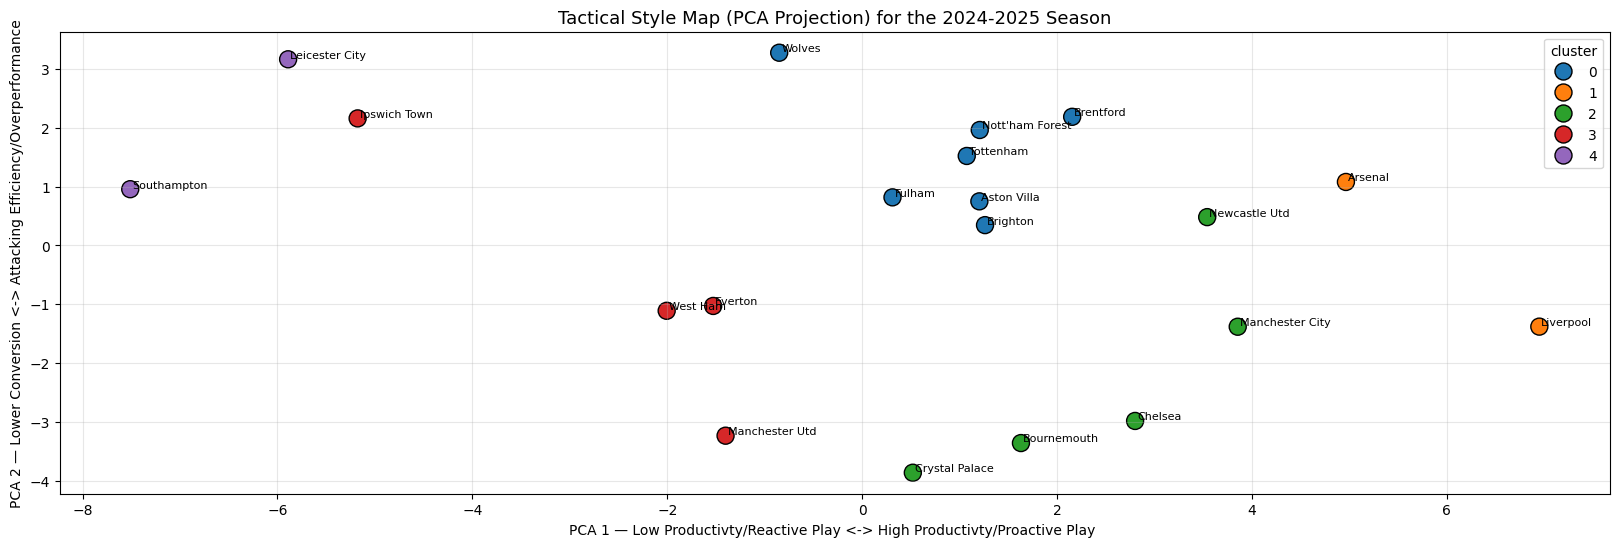

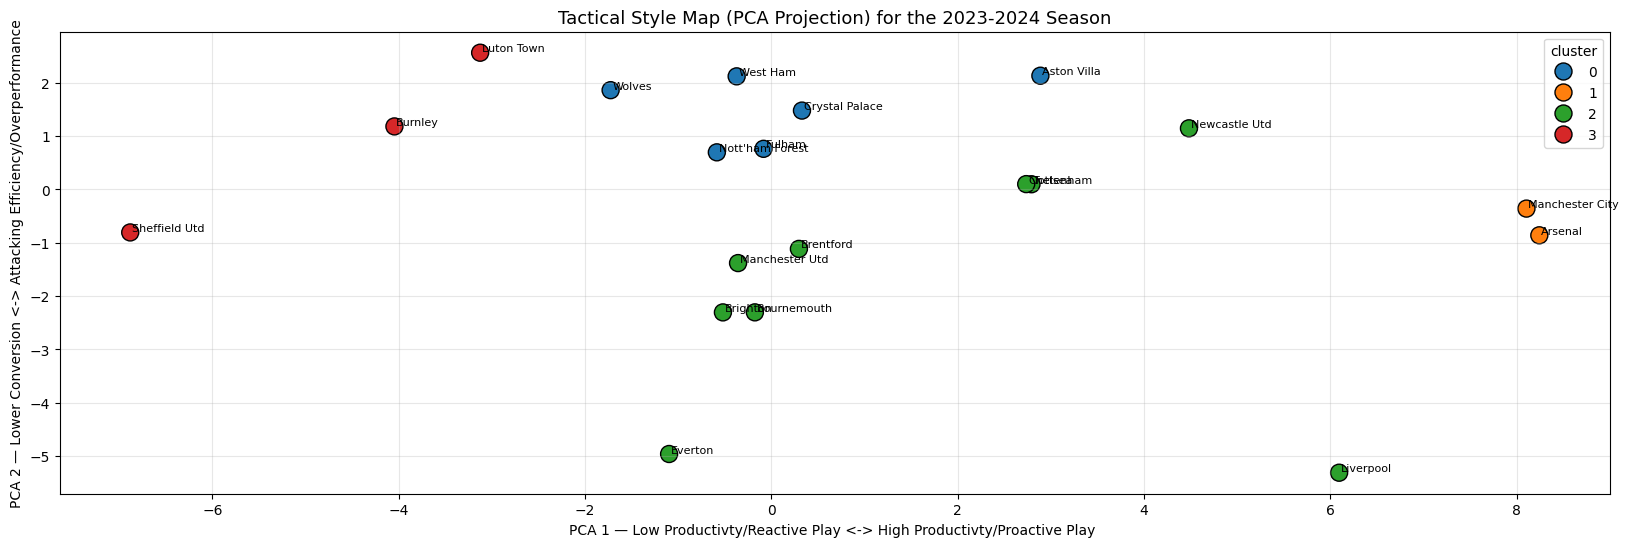

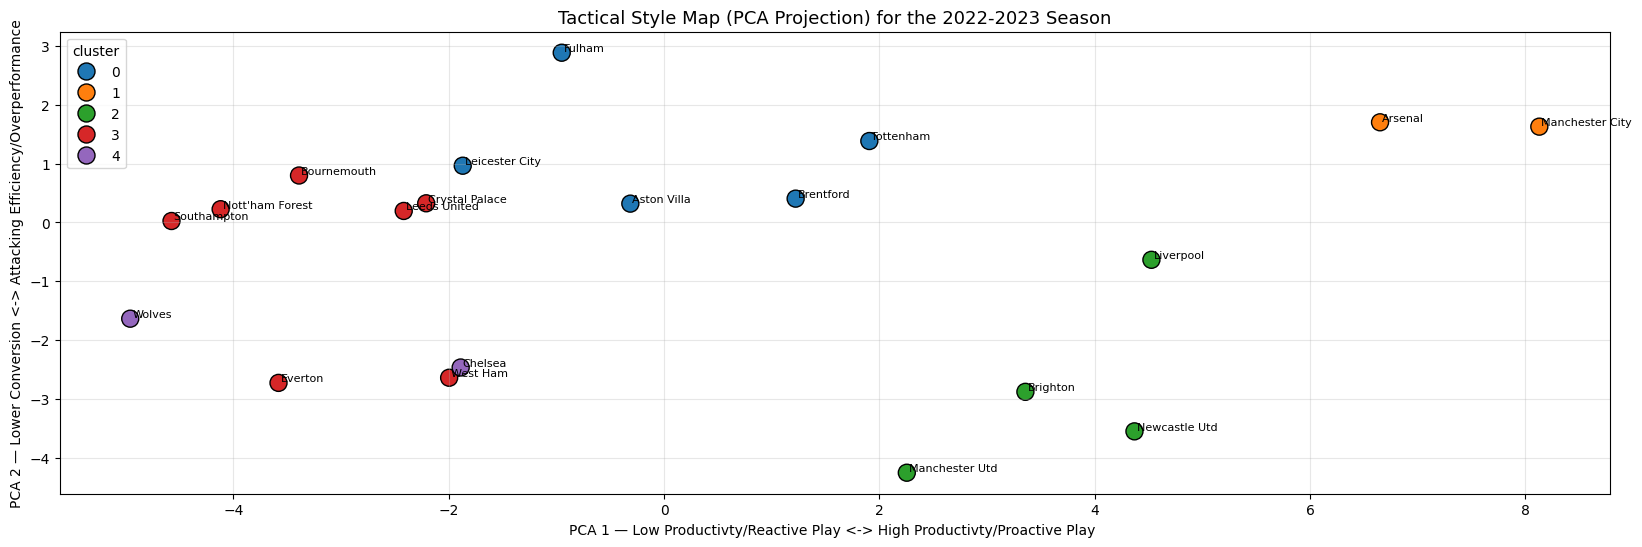

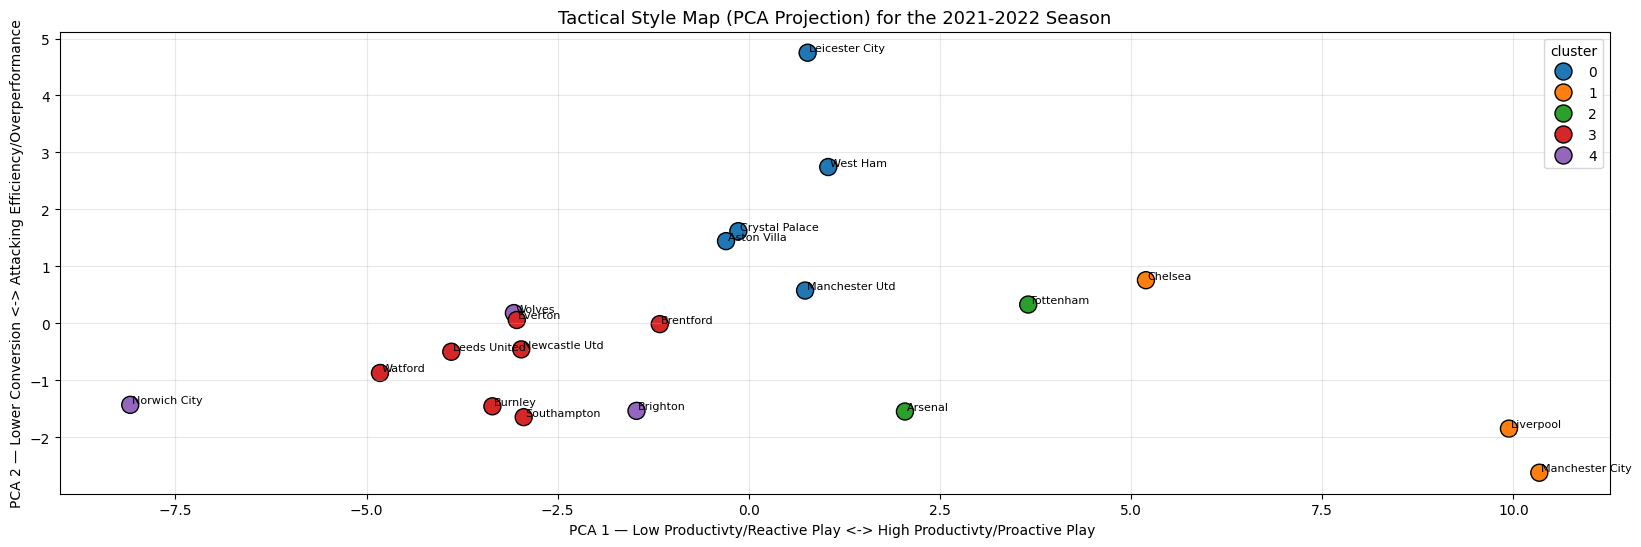

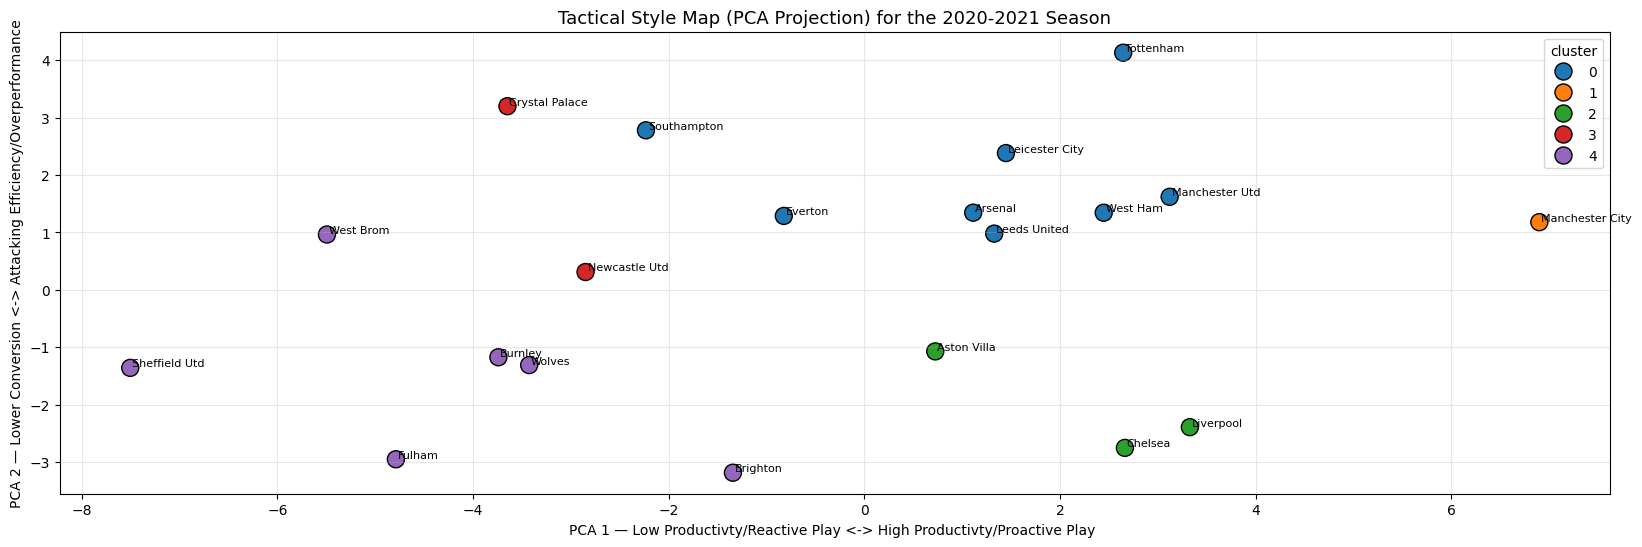

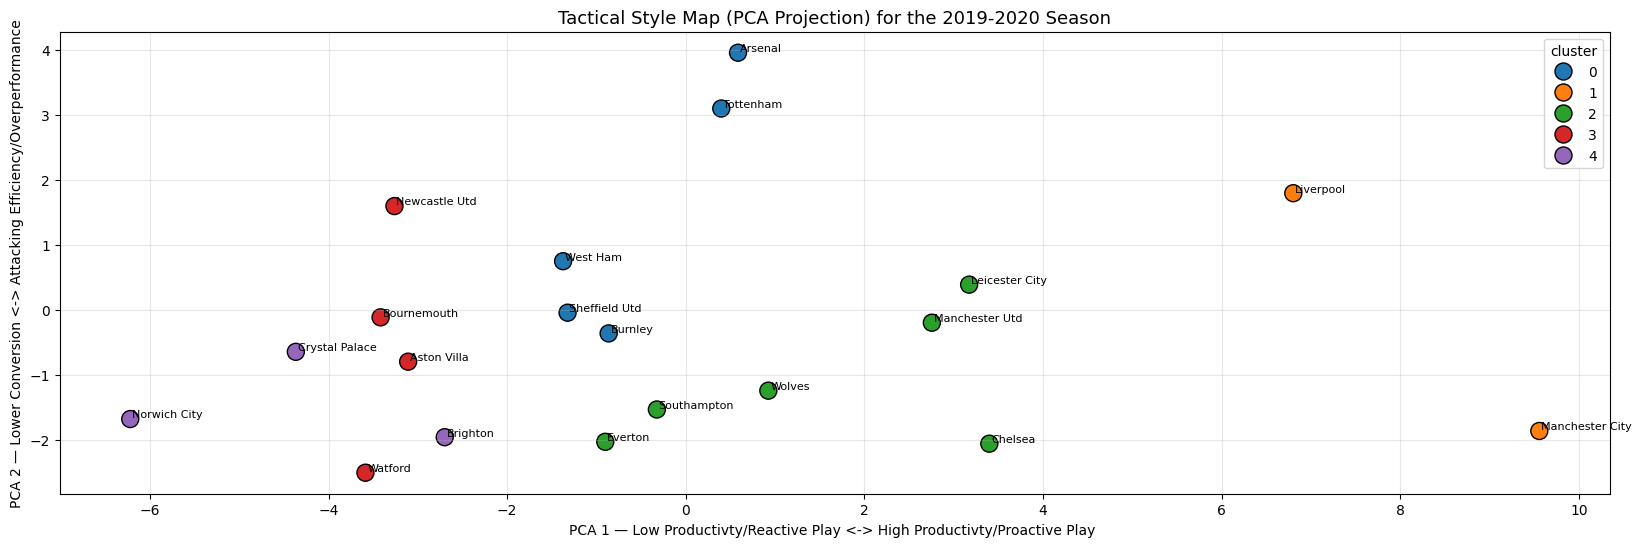

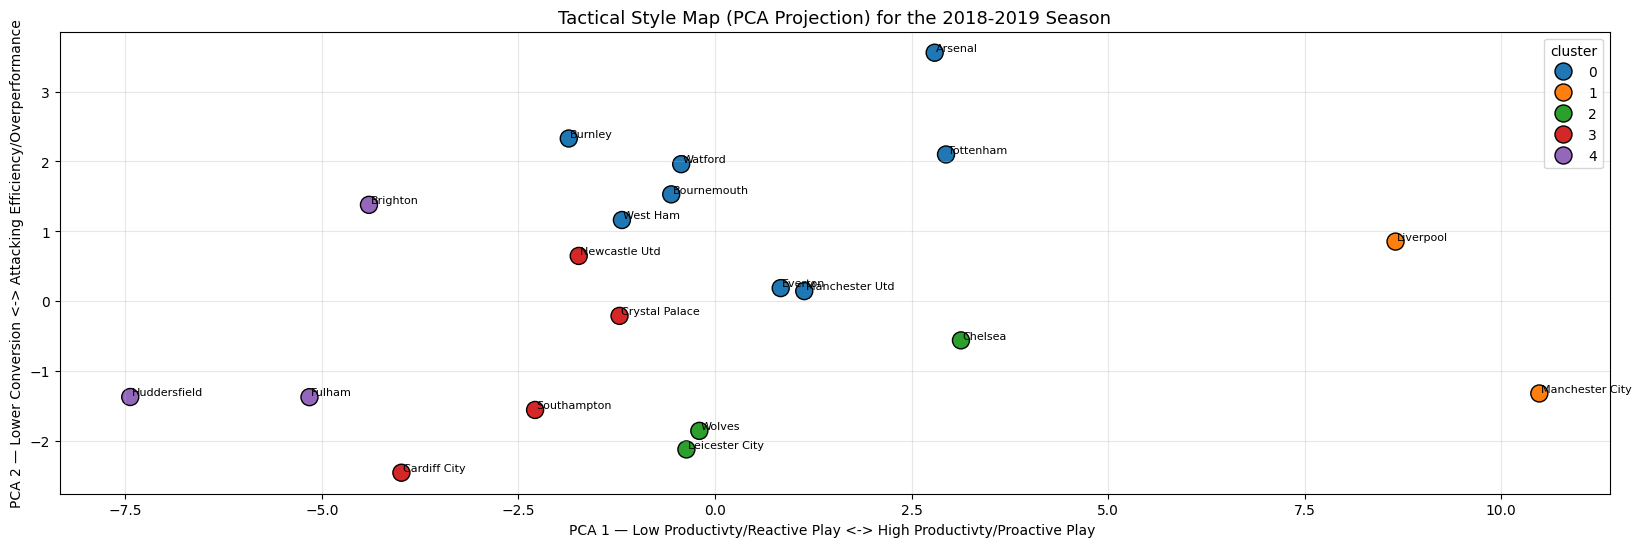

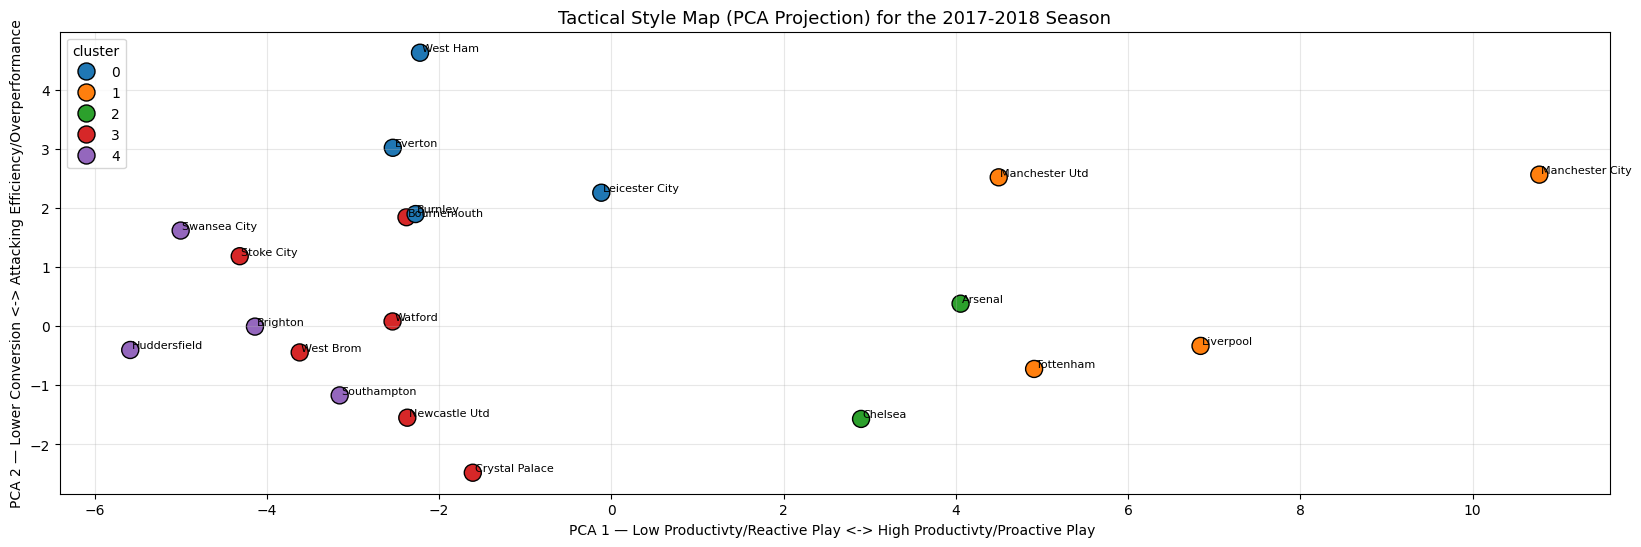

In [50]:

#year = df_clusters[df_clusters['Season'] == '2018-2019']
for season in df_clusters['Season'].unique():
  plt.figure(figsize=(20,6))
  season_df = df_clusters[df_clusters['Season'] == season]
  sns.scatterplot(
      data=season_df,
      x="PCA_1", y="PCA_2",
      hue="cluster",
      palette="tab10",
      s=150,
      edgecolor="black",
      linewidth=1
  )

  # Add team labels
  for _, row in season_df.iterrows():
      plt.text(
          row["PCA_1"] + 0.02,
          row["PCA_2"] + 0.02,
          row["Team"],
          fontsize=8
      )

  plt.title("Tactical Style Map (PCA Projection) for the "+season+" Season", fontsize=13)
  plt.xlabel("PCA 1 — Low Productivty/Reactive Play <-> High Productivty/Proactive Play ", fontsize=10)
  plt.ylabel("PCA 2 — Lower Conversion <-> Attacking Efficiency/Overperformance", fontsize=10)
  plt.grid(alpha=0.3)
  plt.savefig("/content/drive/MyDrive/Data for Colab/tactmapPCA"+season+".png")
  plt.show()

## Data Limitations
The analysis is constrained by the availability of advanced metrics within FBref's StatHead database. While traditional statistics extend back decades, the specific event and possession-based metrics required for this project—such as xG, xAG, shot-quality measures, and buildup indicators—are only consistently available for Premier League teams beginning in the 2017-18 season. This limits the temporal depth of the dataset and reduces the ability to analyze long-term tactical evolution. Additionally, the dataset reflects only league performance, meaning that stylistic variations across competitions (e.g., European tournaments or domestic cups) are not captured. These constraints shape the scope of the clustering results and should be considered when interpreting tactical archetypes.

## Future Work
Several extensions could strengthen and broaden the analysis. Expanding the dataset to include additional competitions—such as the Champions League, Europa League, or top European domestic leagues—would increase sample size and introduce a wider variety of tactical contexts. Incorporating more seasons as advanced metrics become available would allow for longitudinal analysis of tactical evolution. Methodologically, experimenting with alternative clustering algorithms (e.g., Gaussian Mixture Models, HDBSCAN, spectral clustering) and varying the number of PCA components could reveal different structural patterns in the data. Finally, integrating player‑level metrics or possession‑sequence data could enable more granular profiling of tactical behavior beyond team‑season aggregates.
